# Predicción de Quality Leads (QL)
## Problema
Cuando una persona registra su tienda en la plataforma tiene un periodo de prueba de 30 días en los cuales puede decidir si continuar o no utilizando el servicio. Durante el período de prueba la tienda es un trial. Una vez transcurridos los 30 días la tienda puede decidir continuar utilizando el servicio pero de forma paga, en ese caso se convierte en un payment.
En Tienda nuestro objetivo es brindarle a nuestros clientes la mejor calidad de atención. Pero dado el volumen de suscriptores diarios que viene registrando la plataforma de un tiempo a esta parte es muy dificultoso atenderlos a todos a la vez.
Para dar respuesta a este problema es necesario encontrar una forma de priorizar a nuestros clientes. Como Tienda no solo provee un servicio sino que también necesita ganar dinero para poder continuar operando, es necesario dar prioridad a aquellos potenciales clientes (trials) que van a continuar utilizando el servicio y pagando por el mismo (payment).
## Tareas a Desarrollar:
1. Desarrollar uno o varios modelos que permitan predecir con mayor exactitud los trials que se van a convertir en payments
   * Explicar brevemente cual fue el criterio por el cual se eligió el modelo y porqué se seleccionó dicha métrica
2. Obtener al menos 3 (insights) de lo obtenido por el modelo que puedan ser de utilidad para el negocio.


## Diccionario Dataset
* Id: Identificador númerico de los trials
* Country: país de origen del trial
* Creation_platform: plataforma por la cual se creó la tienda
* Admin_visits: cantidad de visitas que registró el administrador
* Intercom_conversations: cantidad de conversaciones que registró la tienda
con el equipo de soporte
* Source_pulido: origen de la tienda por campaña de marketing
* Creation_weekday: día de la semana en que se creó la tienda
* Creation_hour: hora del día en la que se creó la tienda
* Products_with_description: cantidad de productos que poseen descripción
* total_products_with_images: cantidad de productos que poseen imagen
* total_product_categories: cantidad de categorías de productos creadas
* total_events_on_Android: registro de la cantidad de eventos que tuvo el trial
por un dispositivo con sistema operativo Android
* total_events_on_Web: registro de la cantidad de eventos que tuvo el trial por
una computadora
* total_events_on_iOS: registro de la cantidad de eventos que tuvo el trial por un
dispositivo con sistema operativo iOS
* Target:
   * El trial luego del periodo de prueba se convirtió en payment
   * 0: El trial no se convirtió a payment

___
## 0. Imports

In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import pandas as pd
import numpy as np
import scipy
import seaborn as sns
import matplotlib.pyplot as plt
from math import radians
from geopy.geocoders import Nominatim
from sklearn.model_selection import train_test_split

pd.options.mode.chained_assignment = None  # default='warn'

In [3]:
from utils import plot_utils, transform_data

transformer = transform_data.Transformer('nb')

___
## 1. Initial exploratory analysis

In [4]:
# Read dataset
df = pd.read_csv('./data.csv', sep=';')

In [5]:
# Reorder columns by name
df = df.reindex(sorted(df.columns), axis=1)

In [6]:
# Show dataset head
df.head()

,Unnamed: 0,admin_visits,country,creation_hour,creation_platform,creation_weekday,id,intercom_conversations,products_with_description,source_pulido,target,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories,total_products_with_images
0,0,1.0,BR,3,mobile_app,6,589015,0.0,2.0,Other,0,215.0,6.0,0.0,0.0,1
1,1,2.0,BR,3,mobile_web,6,589016,0.0,1.0,Google CPC no Brand,0,0.0,44.0,0.0,0.0,1
2,2,1.0,BR,3,mobile_web,6,589017,0.0,0.0,Google CPC no Brand,0,0.0,16.0,0.0,0.0,0
3,3,1.0,BR,3,mobile_web,6,589018,0.0,0.0,Google CPC no Brand,0,0.0,15.0,0.0,0.0,0
4,4,1.0,BR,3,mobile_web,6,589019,0.0,0.0,Google CPC no Brand,0,0.0,24.0,0.0,0.0,0


In [7]:
df.columns

Index(['Unnamed: 0', 'admin_visits', 'country', 'creation_hour',
       'creation_platform', 'creation_weekday', 'id', 'intercom_conversations',
       'products_with_description', 'source_pulido', 'target',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')

In [8]:
# Delete unnecessary column
df.drop(labels='Unnamed: 0', axis=1, inplace=True)

In [9]:
# Check
df.columns

Index(['admin_visits', 'country', 'creation_hour', 'creation_platform',
       'creation_weekday', 'id', 'intercom_conversations',
       'products_with_description', 'source_pulido', 'target',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')

In [10]:
# Show main statistics
print("Original quantity of examples:", df.shape[0])
print("Original quantity of columns", df.shape[1])
print("Dataset main statistics:")
df.describe()

Original quantity of examples: 585340
Original quantity of columns 15
Dataset main statistics:


,admin_visits,creation_hour,creation_weekday,id,intercom_conversations,products_with_description,target,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories,total_products_with_images
count,585340.000000,585340.000000,585340.000000,5.853400e+05,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000,585340.000000
mean,1.091154,13.565886,2.725496,8.849227e+05,0.005793,5.232655,0.080071,7.105310,68.441636,0.895406,1.289987,5.198054
std,0.543782,7.157861,1.937653,1.711352e+05,0.118485,104.301081,0.271404,36.444225,124.612021,12.274338,9.712947,97.490506
min,0.000000,0.000000,0.000000,5.890150e+05,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000
25%,1.000000,10.000000,1.000000,7.365218e+05,0.000000,0.000000,0.000000,0.000000,11.000000,0.000000,0.000000,0.000000
50%,1.000000,15.000000,3.000000,8.847855e+05,0.000000,0.000000,0.000000,0.000000,27.000000,0.000000,0.000000,0.000000
75%,1.000000,19.000000,4.000000,1.032991e+06,0.000000,1.000000,0.000000,0.000000,70.000000,0.000000,0.000000,1.000000
max,22.000000,23.000000,6.000000,1.181809e+06,27.000000,28530.000000,1.000000,1706.000000,14596.000000,2527.000000,3059.000000,28530.000000


In [11]:
# dataset bigpicture
df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 585340 entries, 0 to 585339
Data columns (total 15 columns):
 #   Column                      Non-Null Count   Dtype  
---  ------                      --------------   -----  
 0   admin_visits                585340 non-null  float64
 1   country                     585340 non-null  object 
 2   creation_hour               585340 non-null  int64  
 3   creation_platform           585340 non-null  object 
 4   creation_weekday            585340 non-null  int64  
 5   id                          585340 non-null  int64  
 6   intercom_conversations      585340 non-null  float64
 7   products_with_description   585340 non-null  float64
 8   source_pulido               585340 non-null  object 
 9   target                      585340 non-null  int64  
 10  total_events_on_Android     585340 non-null  float64
 11  total_events_on_Web         585340 non-null  float64
 12  total_events_on_iOS         585340 non-null  float64
 13  total_product_

### Separation of features and labels

In [12]:
# Distinguishing between features and labels
label = 'target'
Y = df[label].copy()
X = df.drop([label, label], axis=1)
print("df shape:", df.shape)
print("X shape:", X.shape)
print("Y shape:", Y.shape)

df shape: (585340, 15)
X shape: (585340, 14)
Y shape: (585340,)


### Triming dataset based on column datatype

In [13]:
X_float = X.select_dtypes(include='float64')
X_float.shape

(585340, 7)

In [14]:
X_categorical = X.select_dtypes(include='object')
X_categorical.shape

(585340, 3)

In [15]:
X_int = X.select_dtypes(include='int64')
X_int.shape

(585340, 4)

### Analysis of variables 

#### Float variables

In [16]:
pd.concat([X_float.nunique(), X_float.nunique(dropna=False)], axis=1).T

,admin_visits,intercom_conversations,products_with_description,total_events_on_Android,total_events_on_Web,total_events_on_iOS,total_product_categories
0,9,17,1196,776,1479,425,291
1,9,17,1196,776,1479,425,291


No float column has missing values

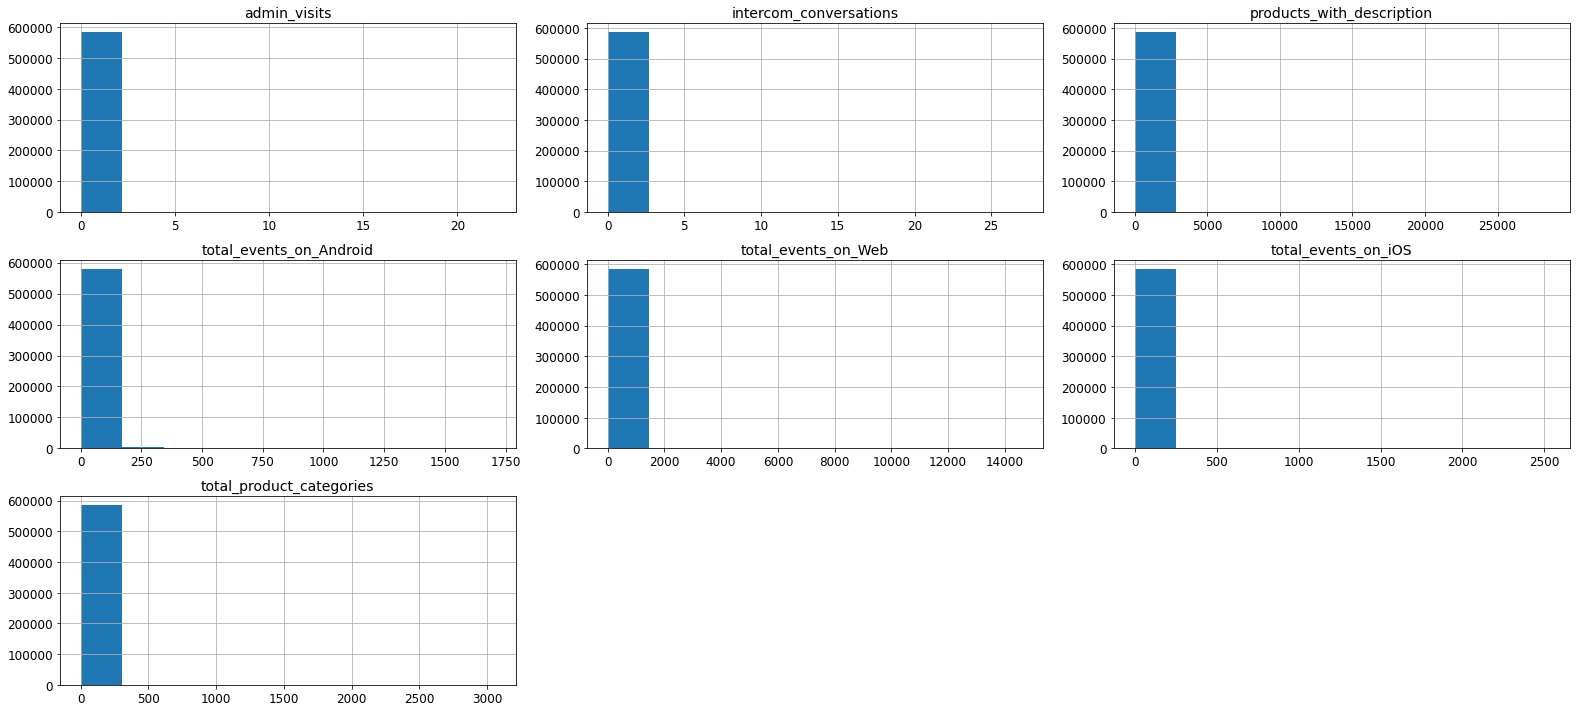

In [17]:
plot_utils.display_dataset_distributions(X_float)

<AxesSubplot:>

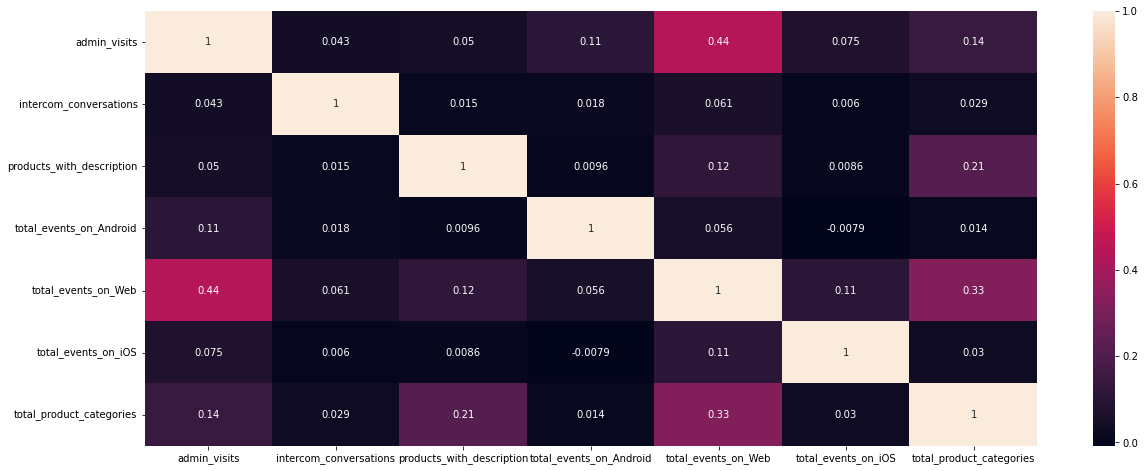

In [18]:
corrmat = X_float.corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables.

#### Integer variables

In [19]:
pd.concat([X_int.nunique(), X_int.nunique(dropna=False)], axis=1).T

,creation_hour,creation_weekday,id,total_products_with_images
0,24,7,585340,1102
1,24,7,585340,1102


No int column has missing values. The *id* column will no be considered fot the next analysis

In [20]:
X_int.drop(labels='id', axis=1, inplace=True)

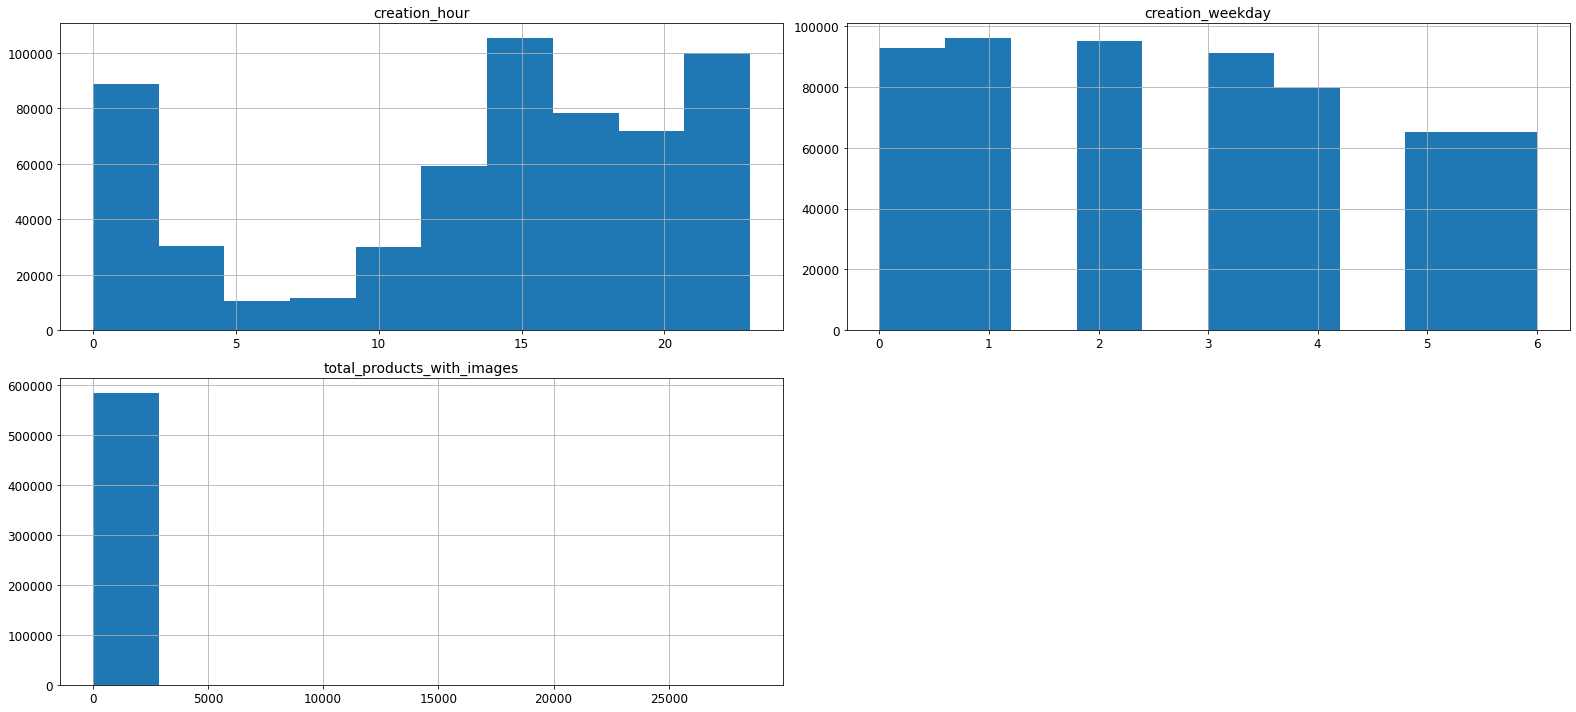

In [21]:
plot_utils.display_dataset_distributions(X_int)

*creation_weekday* and *creation_hour* should be considered as categorical variables

<AxesSubplot:>

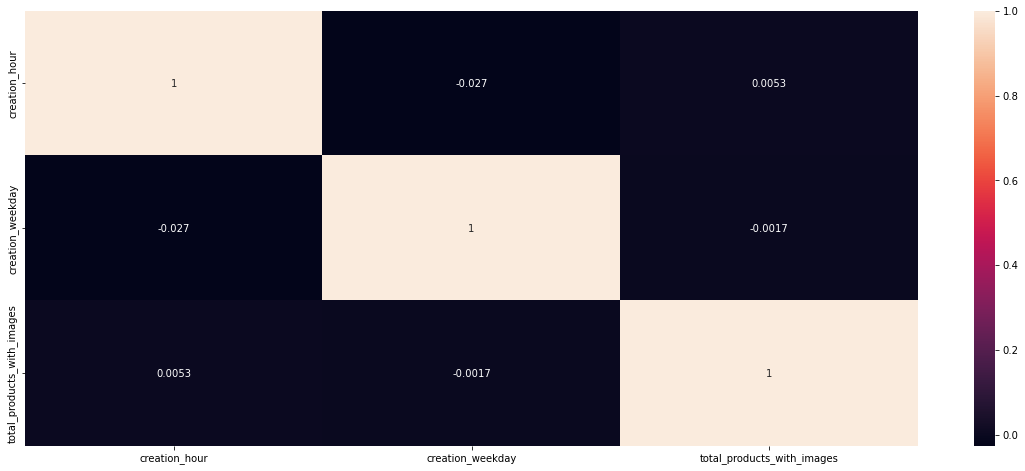

In [22]:
corrmat = X_int.corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables.

<AxesSubplot:>

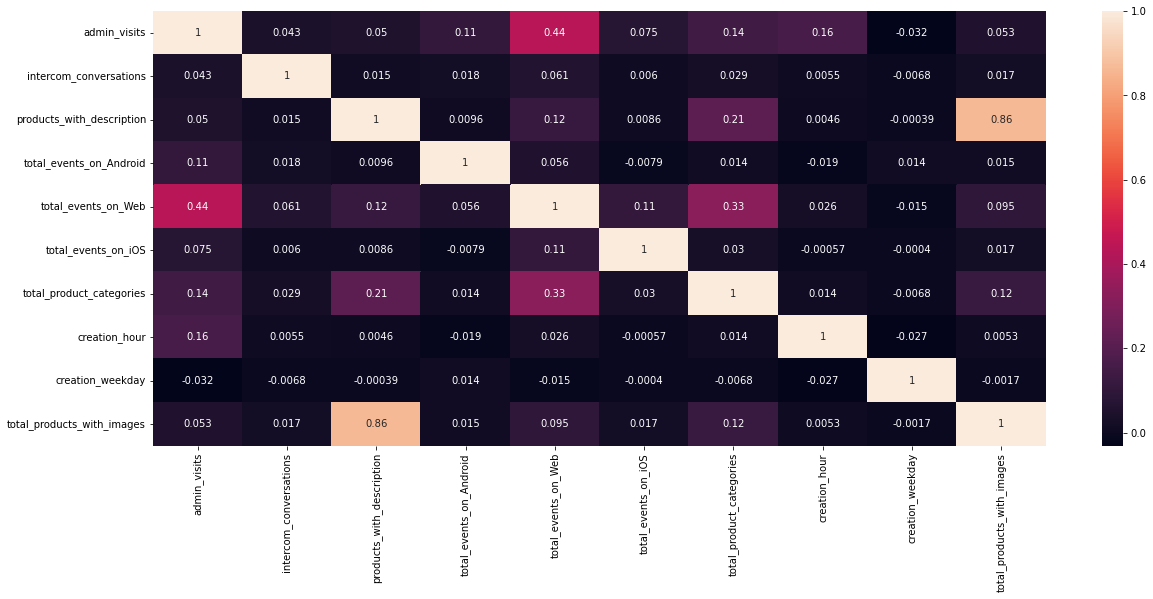

In [23]:
corrmat = pd.concat([X_float, X_int], axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corrmat, annot=True, square=False)

From the correlation matrix above it can be seen that there are no strongly correlated variables (more than 0.9). It can be inferred that sellers who have products with images also add description (in most cases).

#### Categorical variables

In [24]:
X_categorical = pd.concat([X_categorical, X_int[['creation_weekday', 'creation_hour']]], axis=1)

In [25]:
X_int.drop(labels=['creation_weekday', 'creation_hour'], axis=1, inplace=True)

In [26]:
pd.concat([X_categorical.nunique(), X_categorical.nunique(dropna=False)], axis=1).T

,country,creation_platform,source_pulido,creation_weekday,creation_hour
0,5,4,12,7,24
1,5,4,12,7,24


No categorical column has missing values

/Users/ext_asalassa/Documents/CEIA/3erBim/machine-learning-1/TP_FINAL/utils/plot_utils.py:36: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


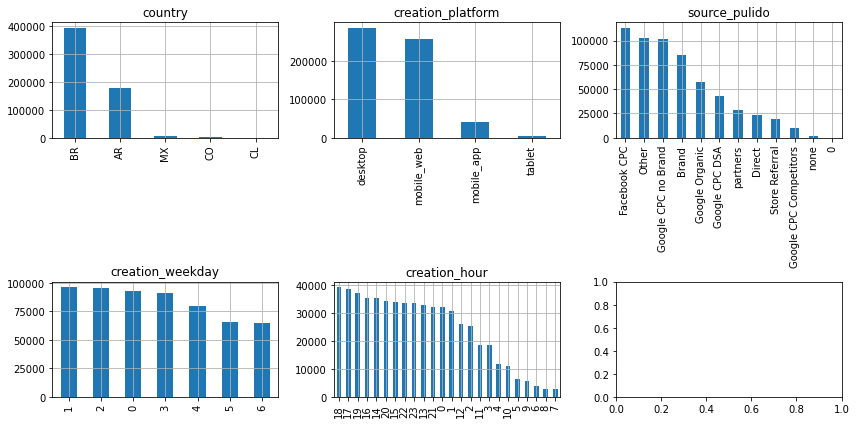

In [27]:
plot_utils.display_dataset_bar_value_count(X_categorical)

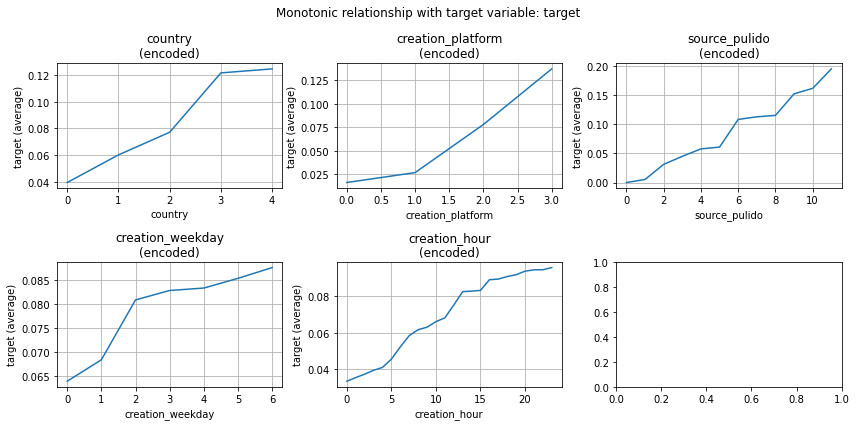

In [28]:
plot_utils.plot_cat_var_relations(X_categorical, Y, column_names=list(X_categorical.columns), label_name=label)

It is observed that all the categorical variables have a monotonic relationship with the target variable. So including them in the classification model would add value.

#### Label

In [29]:
print("Number of distinct values:", Y.nunique())
print("Number of distinct values including missing_values:", Y.nunique(dropna=False))
print("The possible values of Y are:", Y.unique())

Number of distinct values: 2
Number of distinct values including missing_values: 2
The possible values of Y are: [0 1]


There are no missing values in the target column

In [30]:
Y.value_counts()

0    538471
1     46869
Name: target, dtype: int64

In [31]:
y_aux = Y.value_counts()
print('percentage of trails that became payment:', 100*y_aux[1]/np.sum(y_aux))
print('percentage of trails that did not become payment:', 100*y_aux[0]/np.sum(y_aux))

percentage of trails that became payment: 8.00714114873407
percentage of trails that did not become payment: 91.99285885126594


The data is highly imabalanced. Class weights can be used for training

___
## 2. Train-test split

In [32]:
Y = df[label]
X = pd.concat([X_categorical, X_float, X_int], axis=1)
print(len(Y))
print(len(X))
print(X.columns)

585340
585340
Index(['country', 'creation_platform', 'source_pulido', 'creation_weekday',
       'creation_hour', 'admin_visits', 'intercom_conversations',
       'products_with_description', 'total_events_on_Android',
       'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images'],
      dtype='object')


In [33]:
train_proportion = 0.8
#val_proportion = 0.1
test_propportion = 0.2

X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_proportion, test_size=test_propportion, stratify=Y)
#X_train, X_test, y_train, y_test = train_test_split(X, Y, train_size=train_proportion, test_size=val_proportion+test_propportion)
#X_val, X_test, y_val, y_test = train_test_split(X_test, y_test, train_size=val_proportion/(val_proportion+test_propportion), test_size=test_propportion/(val_proportion+test_propportion))

In [34]:
# Reset index is needed to perform transformations
X_train = X_train.reset_index()
#X_val = X_val.reset_index()
X_test = X_test .reset_index()

In [35]:
print("Dataset length:", len(X))
print("Training set length:", len(X_train))
#print("Validation set length:", len(X_val))
print("Test set length:", len(X_test))

Dataset length: 585340
Training set length: 468272
Test set length: 117068


___
## 4. Testing data preprocessing

### 4.1 Categorical variables

Mapping weekdays to avoid column name overlapping 

In [36]:
X_train['creation_weekday'] = X_train['creation_weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})
X_train['creation_weekday']

0            Sunday
1            Monday
2          Saturday
3            Sunday
4          Saturday
            ...    
468267     Thursday
468268       Friday
468269     Thursday
468270    Wednesday
468271     Saturday
Name: creation_weekday, Length: 468272, dtype: object

In [37]:
df_ohe = transformer.one_hot_encoding(X_train[list(X_categorical.columns)])
df_ohe.head()

,AR,BR,CL,CO,MX,desktop,mobile_app,mobile_web,tablet,0,...,14,15,16,17,18,19,20,21,22,23
0,0,1,0,0,0,0,0,1,0,0,...,0,0,0,0,0,1,0,0,0,0
1,0,1,0,0,0,0,0,1,0,0,...,0,1,0,0,0,0,0,0,0,0
2,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,1,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,1,0,0,0,0,1,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [38]:
# Check
pd.concat((X_train[['creation_weekday']], df_ohe[['Monday', 'Tuesday', 'Wednesday', 'Thursday', 'Friday', 'Saturday', 'Sunday']]), axis=1)

,creation_weekday,Monday,Tuesday,Wednesday,Thursday,Friday,Saturday,Sunday
0,Sunday,0,0,0,0,0,0,1
1,Monday,1,0,0,0,0,0,0
2,Saturday,0,0,0,0,0,1,0
3,Sunday,0,0,0,0,0,0,1
4,Saturday,0,0,0,0,0,1,0
...,...,...,...,...,...,...,...,...
468267,Thursday,0,0,0,1,0,0,0
468268,Friday,0,0,0,0,1,0,0
468269,Thursday,0,0,0,1,0,0,0
468270,Wednesday,0,0,1,0,0,0,0


___
## 5. Feature seletion analysis

### 5.1 Numeric variables correlation

In [39]:
# Columnas inicialmente numéricas, previo a transformar.
columns_to_correlate = list(X_float.columns) + list(X_int.columns)
columns_to_correlate

['admin_visits',
 'intercom_conversations',
 'products_with_description',
 'total_events_on_Android',
 'total_events_on_Web',
 'total_events_on_iOS',
 'total_product_categories',
 'total_products_with_images']

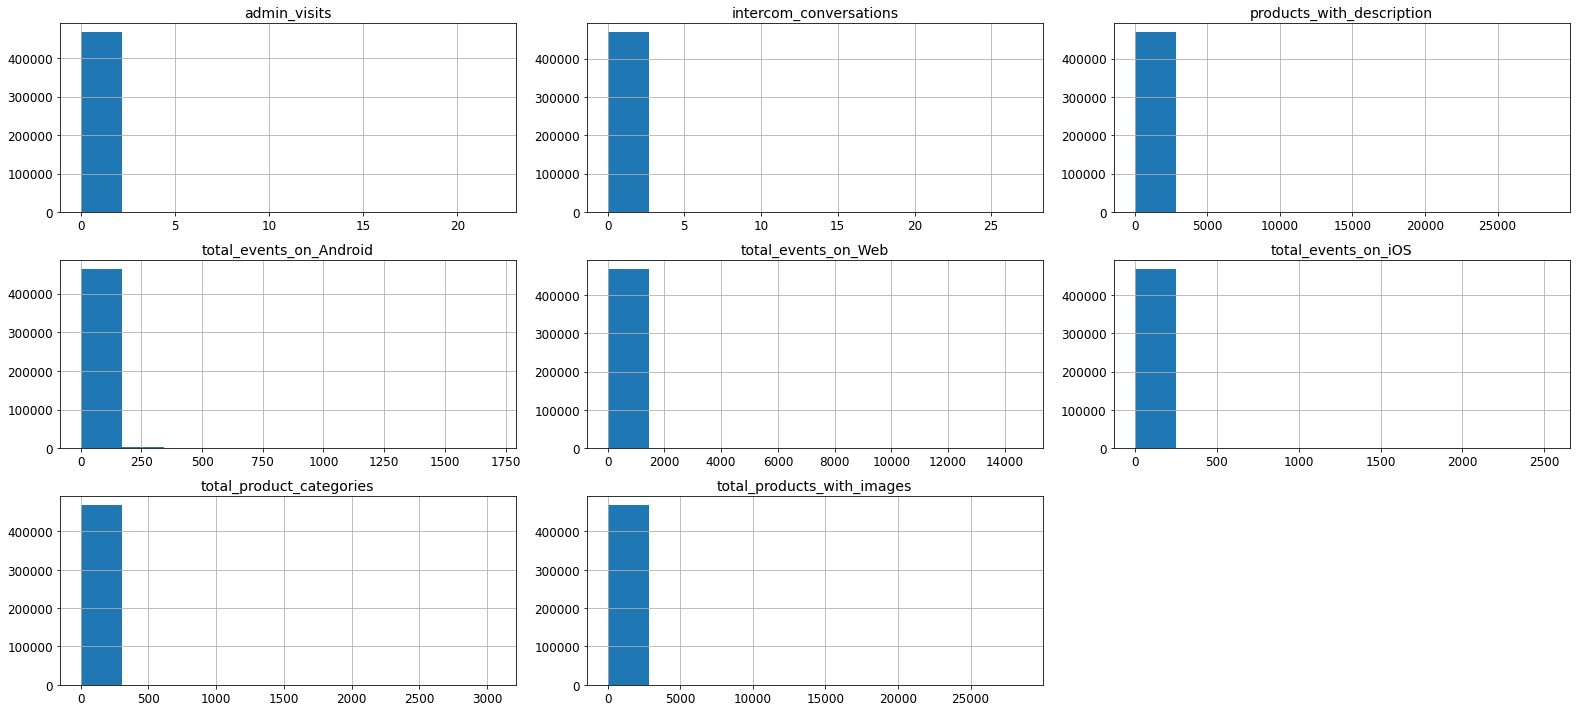

In [40]:
# Correlación sin normalizar
df_corr = X_train[columns_to_correlate].copy()
plot_utils.display_dataset_distributions(df_corr)

<AxesSubplot:>

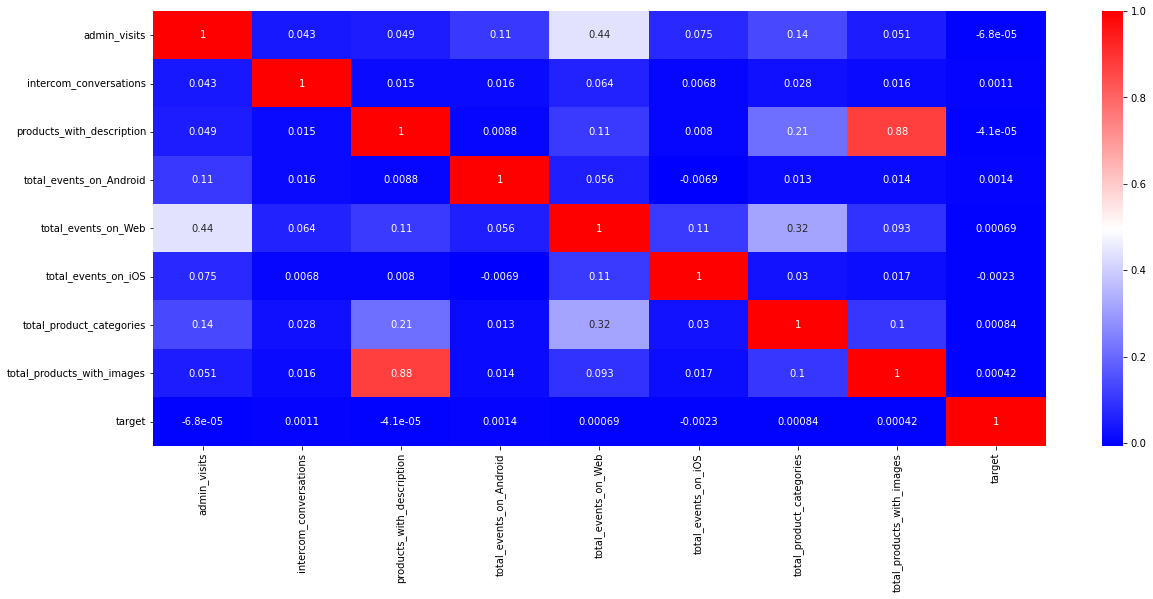

In [41]:
corr_mtx = pd.concat((df_corr, y_train), axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corr_mtx, annot=True, square=False, cmap='bwr')

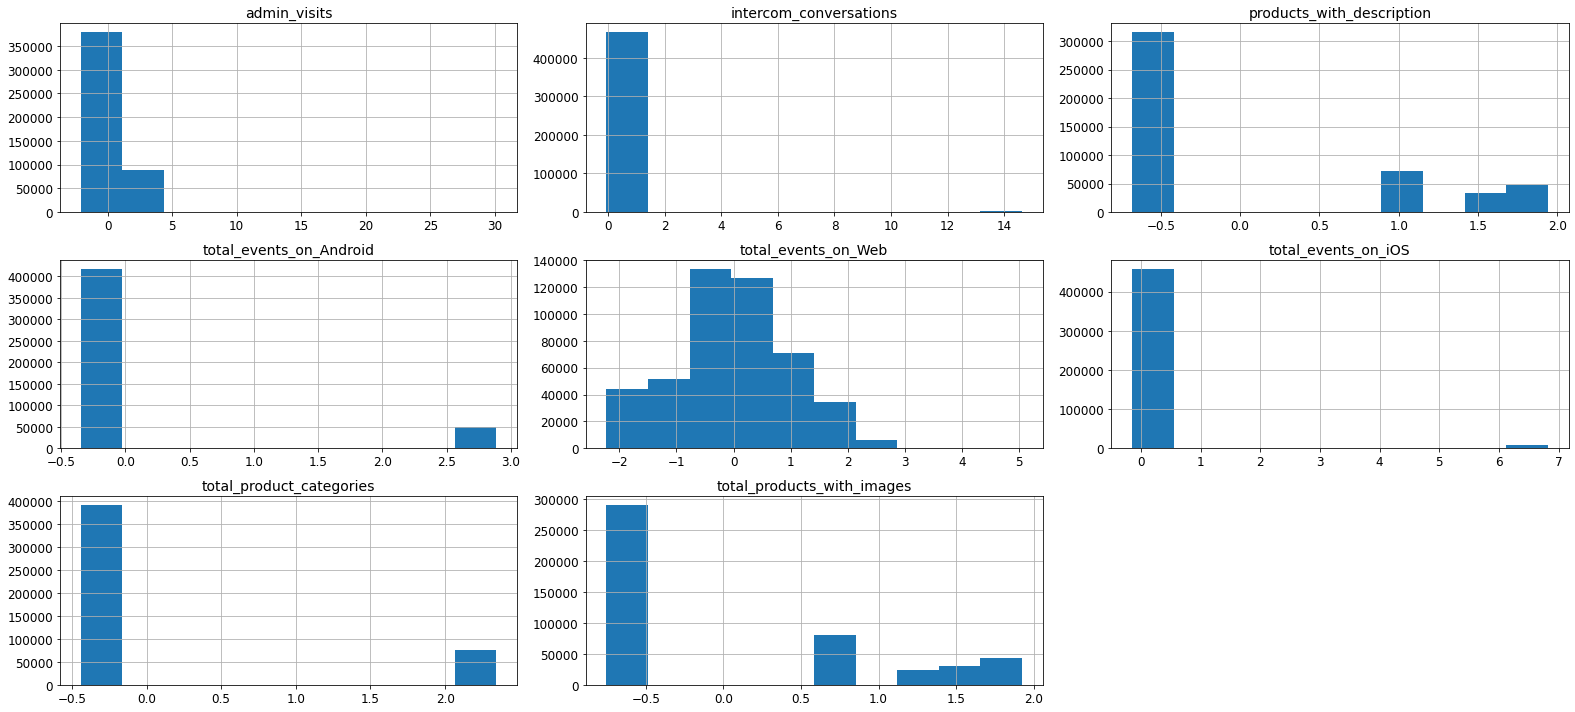

In [42]:
# Correlación normalizando normalizar
df_corr = transformer.power_transform(df_corr)
plot_utils.display_dataset_distributions(df_corr)

<AxesSubplot:>

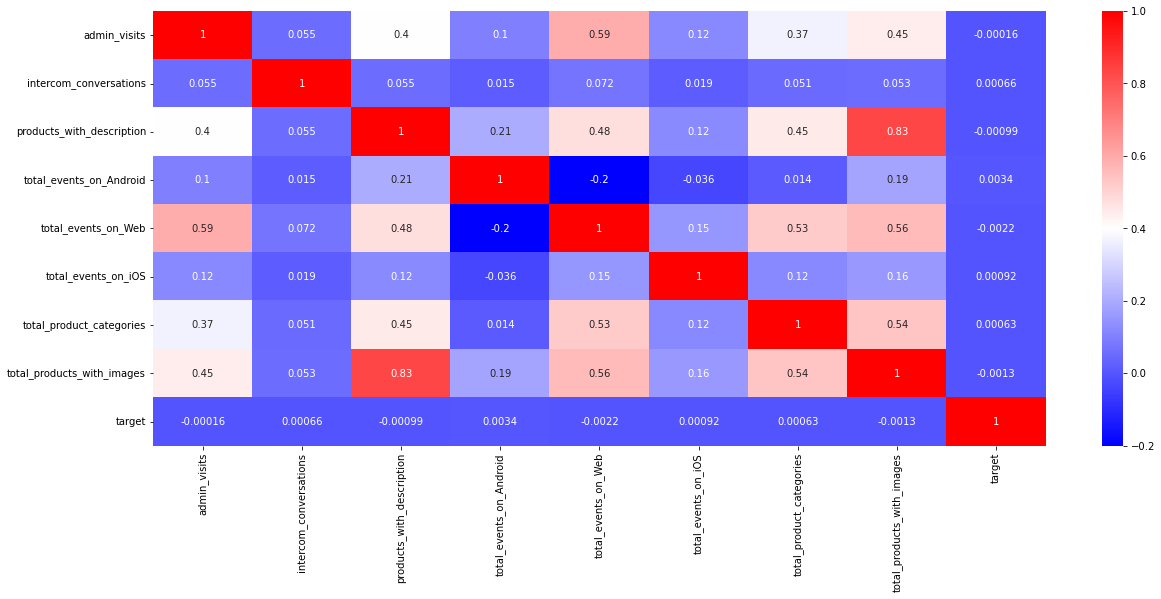

In [43]:
corr_mtx = pd.concat((df_corr, y_train), axis=1).corr()
plt.subplots(figsize=(20,8))
sns.heatmap(corr_mtx, annot=True, square=False, cmap='bwr')

### 5.2 Mutual information

In [44]:
from sklearn.feature_selection import mutual_info_regression

MI = mutual_info_regression(X_train[columns_to_correlate], y_train)

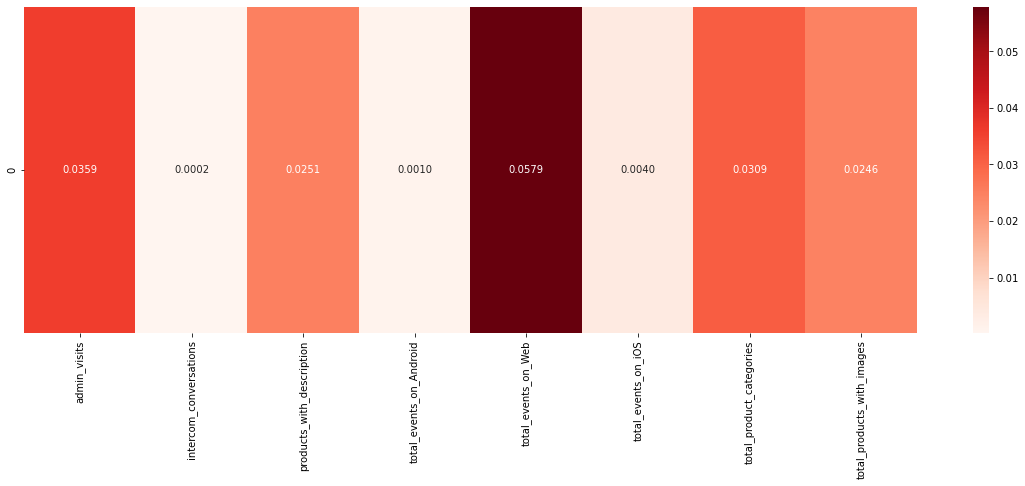

In [45]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_to_correlate)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

Surprisingly there is no mutual information between the Android mobile events and the target

In [46]:
columns_reduced = [
    'admin_visits',
    #'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    #'total_mobile'
 ]

In [47]:
# Trying more variables
X_train['total_events'] = X_train[['total_events_on_Web', 'total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
X_train['total_mobile'] = X_train[['total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
ext_cols = ['total_events', 'total_mobile']

In [48]:
columns_0 = columns_to_correlate

In [49]:
columns_1 = [
    'admin_visits',
    'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    'total_mobile'
 ]
MI_ext_1 = mutual_info_regression(X_train[columns_1], y_train)

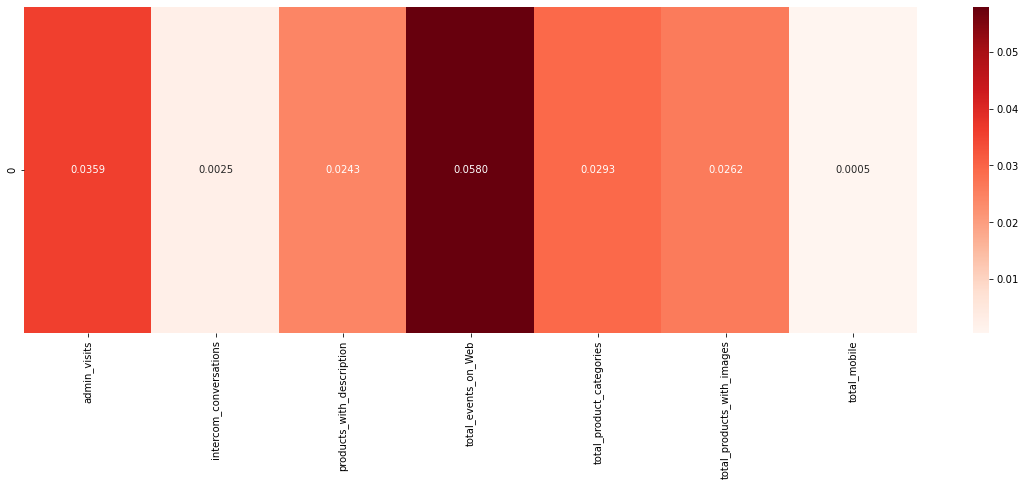

In [50]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI_ext_1], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_1)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

In [51]:
columns_2 = [
    'admin_visits',
    'intercom_conversations',
    'products_with_description',
    #'total_events_on_Android',
    #'total_events_on_Web',
    #'total_events_on_iOS',
    'total_product_categories',
    'total_products_with_images',
    #'total_mobile',
    'total_events'
 ]
MI_ext_2 = mutual_info_regression(X_train[columns_2], y_train)

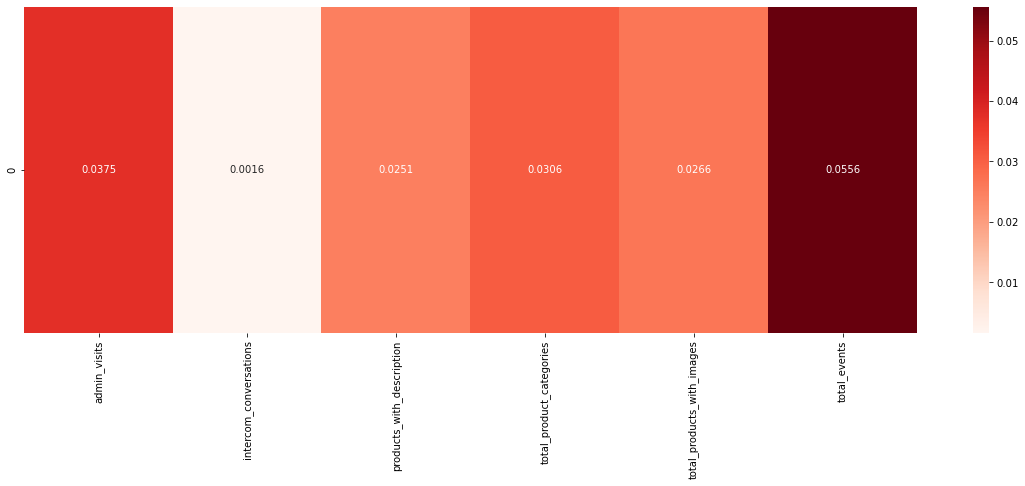

In [52]:
fig, ax = plt.subplots(1,1, figsize=(20,6))

sns.heatmap([MI_ext_2], ax=ax, cmap='Reds', annot=True,fmt=".4f").set_xticklabels(columns_2)
for tick in ax.get_xticklabels():
    tick.set_rotation(90)

#### Define different feature sets based on the previous graphics

In [53]:
fs_0 = list(set(columns_0).union(set(X_categorical.columns)))
fs_1 = list(set(columns_1).union(set(X_categorical.columns)))
fs_2 = list(set(columns_2).union(set(X_categorical.columns)))
fs_3 = list(set(columns_reduced).union(set(X_categorical.columns)))

print('fs_0 - Length:', len(fs_0), fs_0, '\n')
print('fs_1 - Length:', len(fs_1), fs_1, '\n')
print('fs_2 - Length:', len(fs_2), fs_2, '\n')
print('fs_3 - Length:', len(fs_3), fs_3, '\n')

fs_0 - Length: 13 ['creation_hour', 'total_events_on_Android', 'total_products_with_images', 'total_events_on_iOS', 'products_with_description', 'total_events_on_Web', 'country', 'source_pulido', 'creation_weekday', 'intercom_conversations', 'total_product_categories', 'admin_visits', 'creation_platform'] 

fs_1 - Length: 12 ['creation_hour', 'total_mobile', 'total_products_with_images', 'products_with_description', 'total_events_on_Web', 'country', 'source_pulido', 'creation_weekday', 'intercom_conversations', 'total_product_categories', 'admin_visits', 'creation_platform'] 

fs_2 - Length: 11 ['creation_hour', 'total_products_with_images', 'total_events', 'products_with_description', 'country', 'source_pulido', 'creation_weekday', 'intercom_conversations', 'total_product_categories', 'admin_visits', 'creation_platform'] 

fs_3 - Length: 10 ['creation_hour', 'total_products_with_images', 'products_with_description', 'total_events_on_Web', 'country', 'source_pulido', 'creation_weekday'

___
## 6. Training model and evaluation

### 6.0 Complete and transform test set

In [54]:
X_test['total_events'] = X_test[['total_events_on_Web', 'total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)
X_test['total_mobile'] = X_test[['total_events_on_iOS', 'total_events_on_Android']].sum(axis=1)

In [55]:
X_test['creation_weekday'] = X_test['creation_weekday'].map({0: 'Monday', 1: 'Tuesday', 2: 'Wednesday', 3: 'Thursday', 4: 'Friday', 5: 'Saturday', 6: 'Sunday'})

### 6.1 Input data preprocesor pipelines

In [56]:
from sklearn.preprocessing import RobustScaler, StandardScaler, FunctionTransformer, OneHotEncoder
from sklearn.pipeline import Pipeline
from sklearn.compose import ColumnTransformer


numeric_transformer = Pipeline(steps=[
    ('scaler', RobustScaler())])

categorical_transformer = Pipeline(steps=[
    ('onehot', OneHotEncoder(categories="auto", drop=None, sparse=False, handle_unknown="ignore")
)])

categorical_transformer = OneHotEncoder(categories="auto", drop=None, sparse=False, handle_unknown="ignore")

preprocessor_0 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_0),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_1 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_1),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_2 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_2),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

preprocessor_3 = ColumnTransformer(
    transformers=[
        ('num', numeric_transformer, columns_reduced),
        ('cat', categorical_transformer, list(X_categorical.columns)),
    ]
)

### 6.2 Model trainings

In [149]:
from sklearn.metrics import roc_curve, auc, roc_auc_score, precision_recall_curve, accuracy_score, recall_score, f1_score
from sklearn.metrics import classification_report, confusion_matrix

from sklearn.linear_model import LogisticRegression
from sklearn.neural_network import MLPClassifier
from sklearn.ensemble import RandomForestClassifier

import xgboost as xgb

In [58]:
results = {}

#### 6.2.1 Logistic Regression

In [59]:
modelLR_0 = Pipeline(steps=[
                            ('preprocessor', preprocessor_0),
                            ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))
                            ],
                    verbose=True)

In [60]:
modelLR_0.fit(X_train[fs_0], y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   3.8s


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.7s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Android',
                                                   'total_events_on_Web',
                                                   'total_events_on_iOS',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown

Accuracy: 92.02%


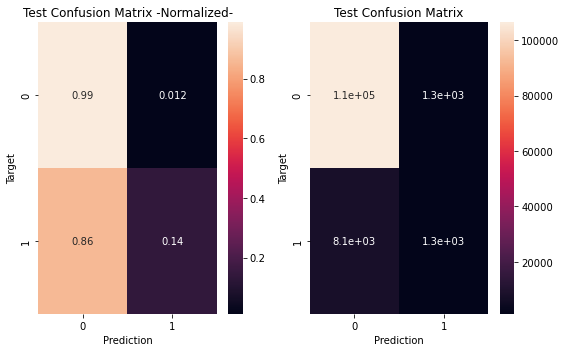

In [61]:
test_preds_LR_0 = modelLR_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_LR_0, y_test, 'Test')
acc = modelLR_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_0)

<ipython-input-62-77603edeaa6a>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


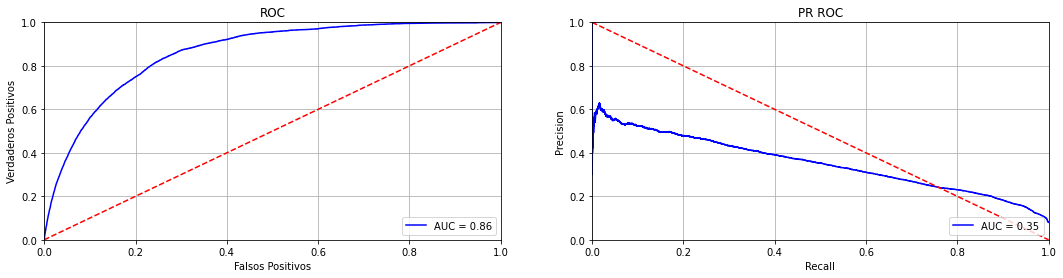

In [62]:
y_pred_LR_0 = modelLR_0.predict_proba(X_test[fs_0])

preds_LR_0 = y_pred_LR_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_0)
roc_auc_LR_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_0)
pr_roc_auc_LR_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [63]:
results['modelLR_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_0, 'prc': pr_roc_auc_LR_0}
results['modelLR_0']

{'acc': 0.9201831414220795,
 'rec': 0.14060166417751227,
 'f1': 0.22003338898163605,
 'auc': 0.86080898542203,
 'prc': 0.35191043997027066}

___

In [64]:
modelLR_1 = Pipeline(steps = [
                            ('preprocessor', preprocessor_1),
                            ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))
                            ],
                    verbose=True)

In [65]:
modelLR_1.fit(X_train[fs_1], y_train)

[Pipeline] ...... (step 1 of 2) Processing preprocessor, total=   1.3s


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.


[Pipeline] ........ (step 2 of 2) Processing classifier, total=   3.3s


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    3.2s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_mobile']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fal

Accuracy: 92.08%


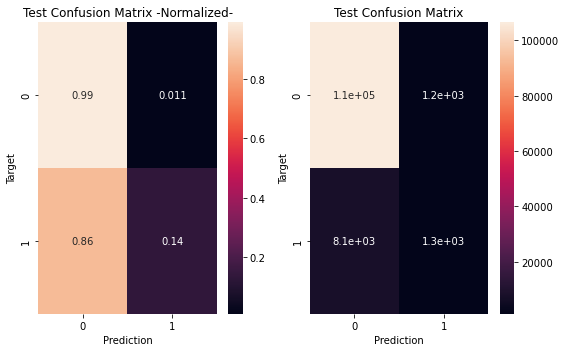

In [66]:
test_preds_LR_1 = modelLR_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_LR_1, y_test, 'Test')
acc = modelLR_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_1)

<ipython-input-67-d04535c8be60>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


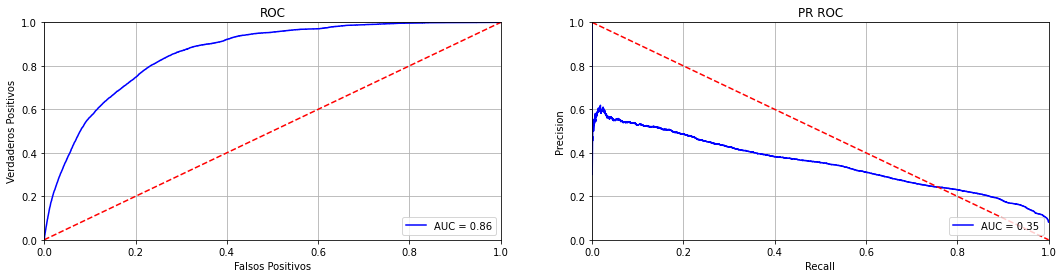

In [67]:
y_pred_LR_1 = modelLR_1.predict_proba(X_test[fs_1])

preds_LR_1 = y_pred_LR_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_1)
roc_auc_LR_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_1)
pr_roc_auc_LR_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [68]:
results['modelLR_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_1, 'prc': pr_roc_auc_LR_1}
results['modelLR_1']

{'acc': 0.9207810844978986,
 'rec': 0.13644122039684234,
 'f1': 0.21619337390128462,
 'auc': 0.8607940060786456,
 'prc': 0.35140499494849686}

___

In [69]:
modelLR_2 = Pipeline(steps=[('preprocessor', preprocessor_2),
                       ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))])

In [70]:
modelLR_2.fit(X_train[fs_2], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_events']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
       

Accuracy: 92.04%


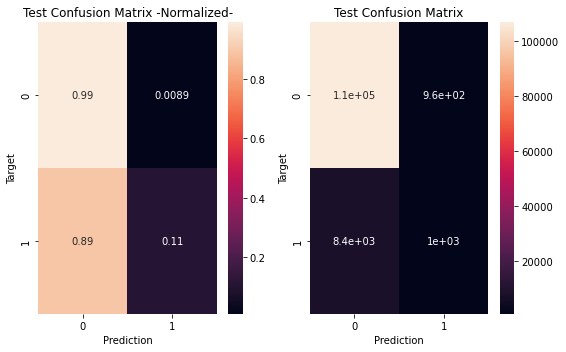

In [71]:
test_preds_LR_2 = modelLR_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_LR_2, y_test, 'Test')
acc = modelLR_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_2)

<ipython-input-72-b7bb523ac856>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


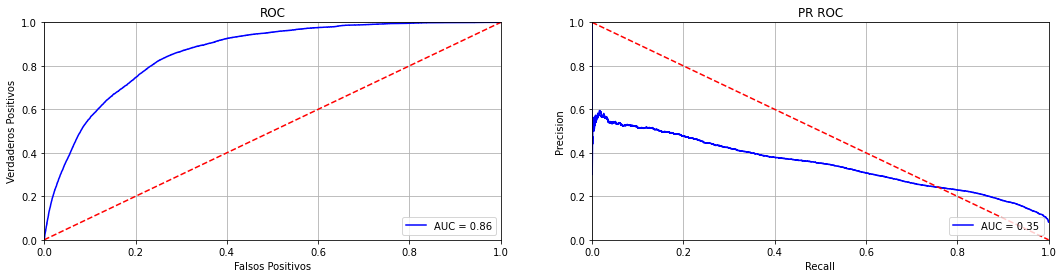

In [72]:
y_pred_LR_2 = modelLR_2.predict_proba(X_test[fs_2])

preds_LR_2 = y_pred_LR_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_2)
roc_auc_LR_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_2)
pr_roc_auc_LR_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [73]:
results['modelLR_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_2, 'prc': pr_roc_auc_LR_2}
results['modelLR_2']

{'acc': 0.9204137766084669,
 'rec': 0.108491572434393,
 'f1': 0.17919126068187824,
 'auc': 0.860456745993949,
 'prc': 0.34709128319092786}

___

In [74]:
modelLR_3 = Pipeline(steps=[('preprocessor', preprocessor_3),
                       ('classifier', LogisticRegression(verbose=True, max_iter=50, tol = 0.00001))])

In [75]:
modelLR_3.fit(X_train[fs_3], y_train)

[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/linear_model/_logistic.py:763: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  n_iter_i = _check_optimize_result(
[Parallel(n_jobs=1)]: Done   1 out of   1 | elapsed:    2.8s finished


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
                                                   'creation_platform',
     

Accuracy: 92.09%


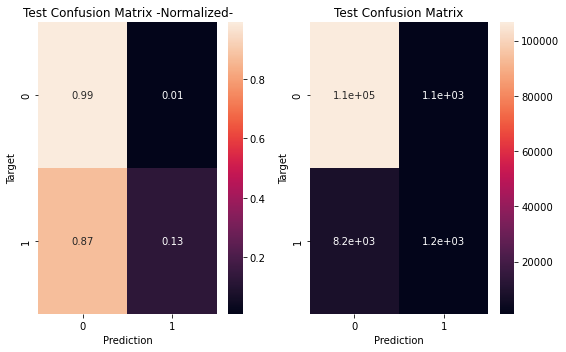

In [76]:
test_preds_LR_3 = modelLR_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_LR_3, y_test, 'Test')
acc = modelLR_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_LR_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_LR_3)

<ipython-input-77-e3974ef103d2>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


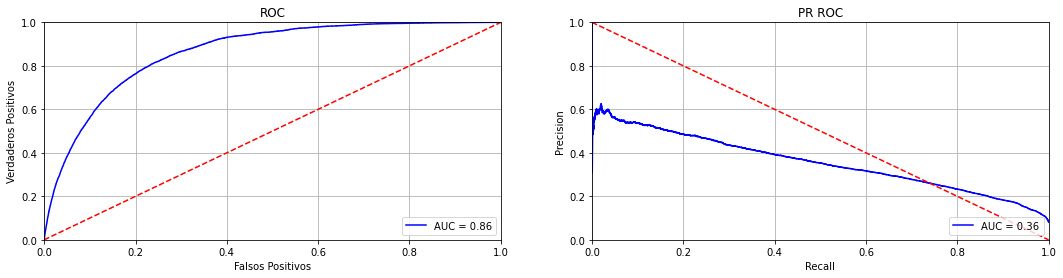

In [77]:
y_pred_LR_3 = modelLR_3.predict_proba(X_test[fs_3])

preds_LR_3 = y_pred_LR_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_LR_3)
roc_auc_LR_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_LR_3)
pr_roc_auc_LR_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_LR_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_LR_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [78]:
results['modelLR_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_LR_3, 'prc': pr_roc_auc_LR_3}
results['modelLR_3']

{'acc': 0.9209348412888236,
 'rec': 0.12801365478984425,
 'f1': 0.2059025394646534,
 'auc': 0.8642445194215953,
 'prc': 0.3567095742458375}

#### 6.2.2 Random forest

In [79]:
modelRF_0 = Pipeline(steps=[('preprocessor', preprocessor_0),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [80]:
modelRF_0.fit(X_train[fs_0], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Android',
                                                   'total_events_on_Web',
                                                   'total_events_on_iOS',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown

Accuracy: 91.25%


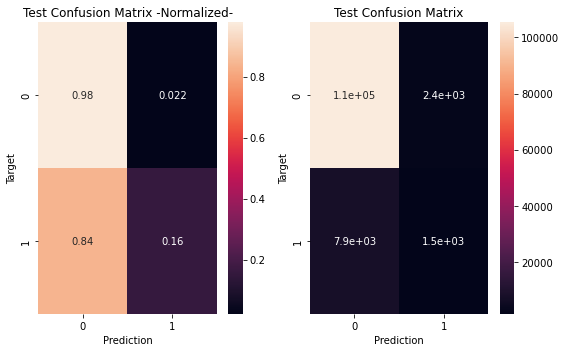

In [81]:
test_preds_RF_0 = modelRF_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_RF_0, y_test, 'Test')
acc = modelRF_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_0)

<ipython-input-82-5dd9bcfb54c3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


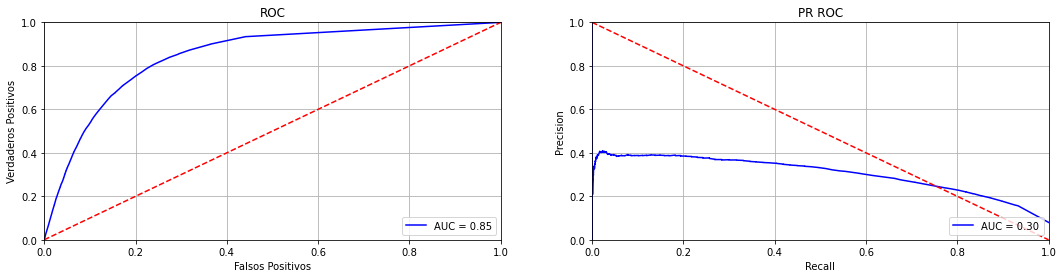

In [82]:
y_pred_RF_0 = modelRF_0.predict_proba(X_test[fs_0])

preds_RF_0 = y_pred_RF_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_0)
roc_auc_RF_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_0)
pr_roc_auc_RF_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [83]:
results['modelRF_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_0, 'prc': pr_roc_auc_RF_0}
results['modelRF_0']

{'acc': 0.9125123859637134,
 'rec': 0.15831021975677406,
 'f1': 0.2246782740348221,
 'auc': 0.845631859629435,
 'prc': 0.30358994050809934}

___

In [84]:
modelRF_1 = Pipeline(steps=[('preprocessor', preprocessor_1),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [85]:
modelRF_1.fit(X_train[fs_1], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_mobile']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fal

Accuracy: 91.29%


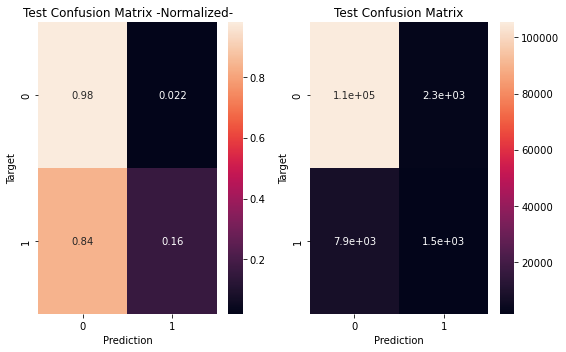

In [86]:
test_preds_RF_1 = modelRF_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_RF_1, y_test, 'Test')
acc = modelRF_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_1)

<ipython-input-87-b9313fc5ab1c>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


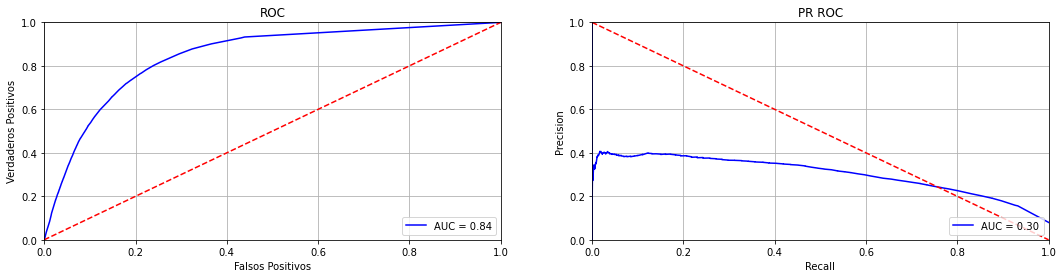

In [87]:
y_pred_RF_1 = modelRF_1.predict_proba(X_test[fs_1])

preds_RF_1 = y_pred_RF_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_1)
roc_auc_RF_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_1)
pr_roc_auc_RF_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [88]:
results['modelRF_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_1, 'prc': pr_roc_auc_RF_1}
results['modelRF_1']

{'acc': 0.912905319984966,
 'rec': 0.16097717089822913,
 'f1': 0.2283941274405933,
 'auc': 0.8445024971760045,
 'prc': 0.3029520818394469}

___

In [89]:
modelRF_2 = Pipeline(steps=[('preprocessor', preprocessor_2),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [90]:
modelRF_2.fit(X_train[fs_2], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_events']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
       

Accuracy: 91.23%


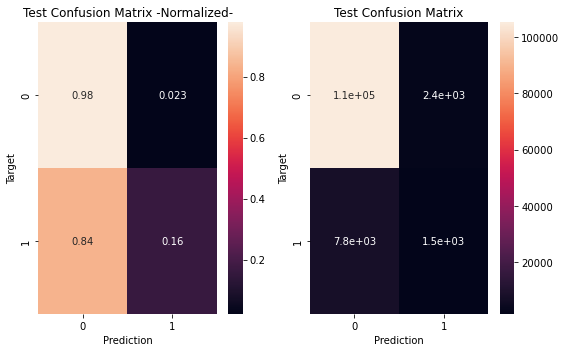

In [91]:
test_preds_RF_2 = modelRF_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_RF_2, y_test, 'Test')
acc = modelRF_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_2)

<ipython-input-92-dce0f61cf5d7>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


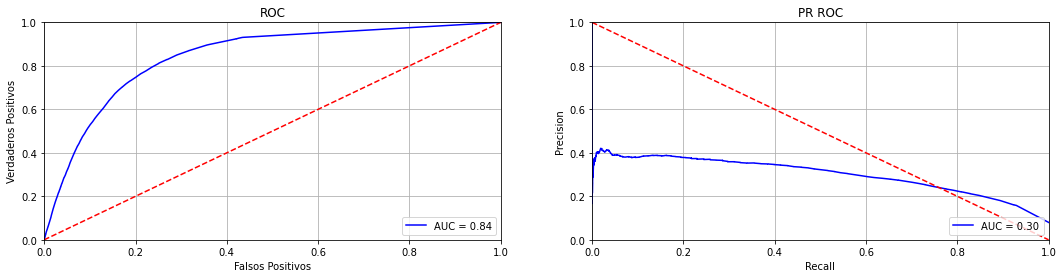

In [92]:
y_pred_RF_2 = modelRF_2.predict_proba(X_test[fs_2])

preds_RF_2 = y_pred_RF_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_2)
roc_auc_RF_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_2)
pr_roc_auc_RF_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [93]:
results['modelRF_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_2, 'prc': pr_roc_auc_RF_2}
results['modelRF_2']

{'acc': 0.9122646666894455,
 'rec': 0.16343076594836783,
 'f1': 0.2297712785901762,
 'auc': 0.8428435190471177,
 'prc': 0.2995997050368715}

___

In [94]:
modelRF_3 = Pipeline(steps=[('preprocessor', preprocessor_3),
                       ('classifier', RandomForestClassifier(n_estimators=100, criterion='entropy', max_depth=None, random_state=0))])

In [95]:
modelRF_3.fit(X_train[fs_3], y_train)

Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
                                                   'creation_platform',
     

Accuracy: 91.22%


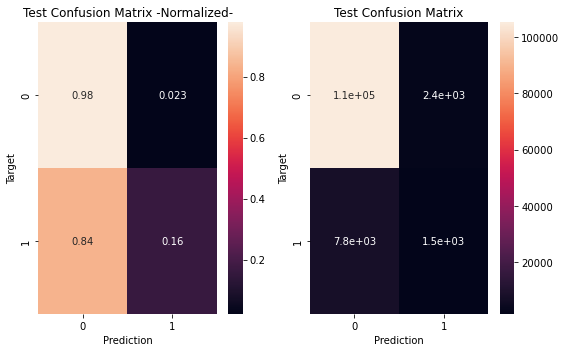

In [96]:
test_preds_RF_3 = modelRF_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_RF_3, y_test, 'Test')
acc = modelRF_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_RF_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_RF_3)

<ipython-input-97-ada330219aa6>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


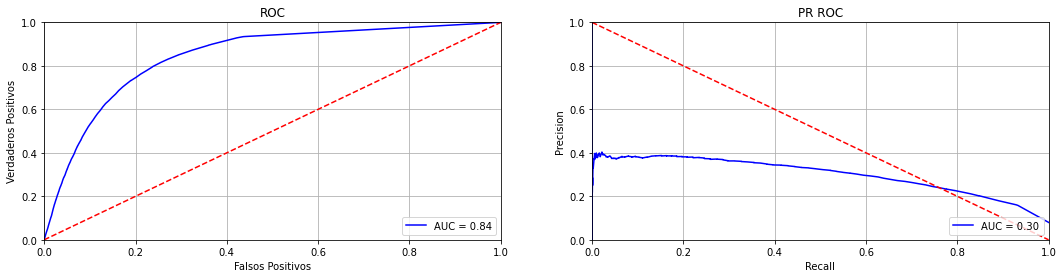

In [97]:
y_pred_RF_3 = modelRF_3.predict_proba(X_test[fs_3])

preds_RF_3 = y_pred_RF_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_RF_3)
roc_auc_RF_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_RF_3)
pr_roc_auc_RF_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_RF_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_RF_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [98]:
results['modelRF_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_RF_3, 'prc': pr_roc_auc_RF_3}
results['modelRF_3']

{'acc': 0.9121621621621622,
 'rec': 0.16353744399402603,
 'f1': 0.22968012585212375,
 'auc': 0.8438922182019892,
 'prc': 0.29968699870054005}

#### 6.2.3 Neural Network

In [99]:
modelNN_0 = Pipeline(steps=[
    ('preprocessor', preprocessor_0),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=10, alpha=0.001, random_state=0))
])

In [100]:
modelNN_0.fit(X_train[fs_0], y_train)

Iteration 1, loss = 0.21007212
Iteration 2, loss = 0.19984923
Iteration 3, loss = 0.19953024
Iteration 4, loss = 0.19853402
Iteration 5, loss = 0.19867737
Iteration 6, loss = 0.19818512
Iteration 7, loss = 0.19812565
Iteration 8, loss = 0.19812713
Iteration 9, loss = 0.19779665
Iteration 10, loss = 0.19798336


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (10) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Android',
                                                   'total_events_on_Web',
                                                   'total_events_on_iOS',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown

Accuracy: 92.05%


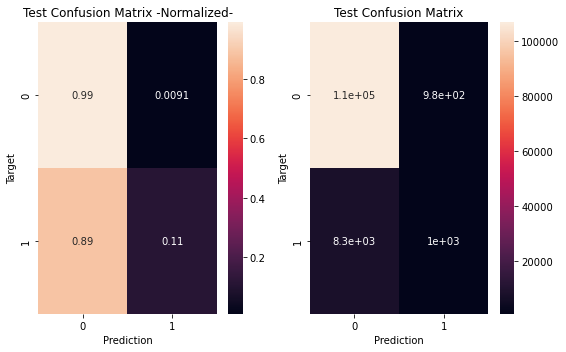

In [101]:
test_preds_NN_0 = modelNN_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_NN_0, y_test, 'Test')
acc = modelNN_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_0)

<ipython-input-102-83cb0fc8e883>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


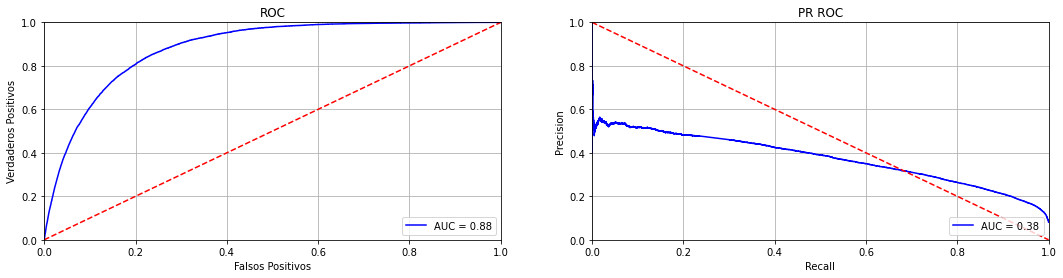

In [102]:
y_pred_NN_0 = modelNN_0.predict_proba(X_test[fs_0])

preds_NN_0 = y_pred_NN_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_0)
roc_auc_NN_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_0)
pr_roc_auc_NN_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [103]:
results['modelNN_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_0, 'prc': pr_roc_auc_NN_0}
results['modelNN_0']

{'acc': 0.9204564868281683,
 'rec': 0.1112652016215063,
 'f1': 0.18301456395858923,
 'auc': 0.8836785369671949,
 'prc': 0.37553474669120646}

___

In [104]:
modelNN_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=20, alpha=0.001, random_state=1))
])

In [105]:
modelNN_1.fit(X_train[fs_1], y_train)

Iteration 1, loss = 0.22283946
Iteration 2, loss = 0.20032315
Iteration 3, loss = 0.19992095
Iteration 4, loss = 0.19863959
Iteration 5, loss = 0.19852812
Iteration 6, loss = 0.19806732
Iteration 7, loss = 0.19855954
Iteration 8, loss = 0.19815184
Iteration 9, loss = 0.19785835
Iteration 10, loss = 0.19786529
Iteration 11, loss = 0.19797850
Iteration 12, loss = 0.19811754
Iteration 13, loss = 0.19792880
Iteration 14, loss = 0.19755170
Iteration 15, loss = 0.19795584
Iteration 16, loss = 0.19788904
Iteration 17, loss = 0.19796353
Iteration 18, loss = 0.19774147
Iteration 19, loss = 0.19770271
Iteration 20, loss = 0.19742238


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (20) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_mobile']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fal

Accuracy: 92.18%


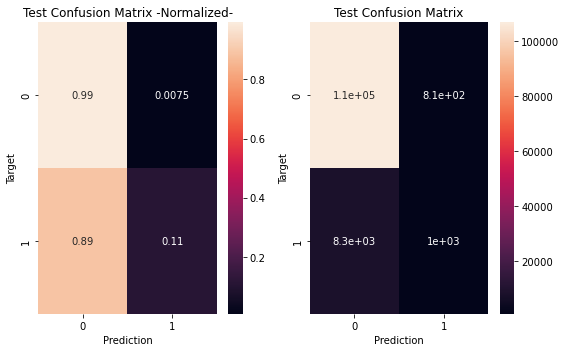

In [106]:
test_preds_NN_1 = modelNN_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_NN_1, y_test, 'Test')
acc = modelNN_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_1)

<ipython-input-107-5262c2d92ace>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


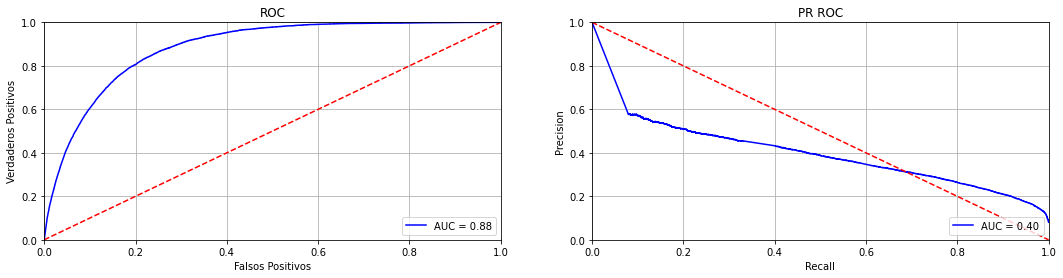

In [107]:
y_pred_NN_1 = modelNN_1.predict_proba(X_test[fs_1])

preds_NN_1 = y_pred_NN_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_1)
roc_auc_NN_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_1)
pr_roc_auc_NN_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [108]:
results['modelNN_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_1, 'prc': pr_roc_auc_NN_1}
results['modelNN_1']

{'acc': 0.9218317559025524,
 'rec': 0.11009174311926606,
 'f1': 0.18403923316986182,
 'auc': 0.8840058215541035,
 'prc': 0.40170225020350353}

___

In [182]:
modelNN_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=19, alpha=0.001, random_state=1))
])

In [183]:
modelNN_2.fit(X_train[fs_2], y_train)

Iteration 1, loss = 0.29412255
Iteration 2, loss = 0.27895681
Iteration 3, loss = 0.27896089
Iteration 4, loss = 0.27896905
Iteration 5, loss = 0.27897162
Iteration 6, loss = 0.27896856
Iteration 7, loss = 0.27897534
Iteration 8, loss = 0.27898361
Iteration 9, loss = 0.27897980
Iteration 10, loss = 0.27897887
Iteration 11, loss = 0.27897404
Iteration 12, loss = 0.27896117
Iteration 13, loss = 0.27896202
Training loss did not improve more than tol=0.000100 for 10 consecutive epochs. Stopping.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_events']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
       

Accuracy: 91.99%


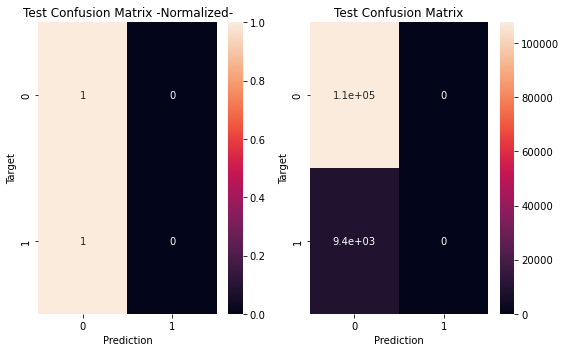

In [184]:
test_preds_NN_2 = modelNN_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_NN_2, y_test, 'Test')
acc = modelNN_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_2)

<ipython-input-185-ddaa5d2b5ea5>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


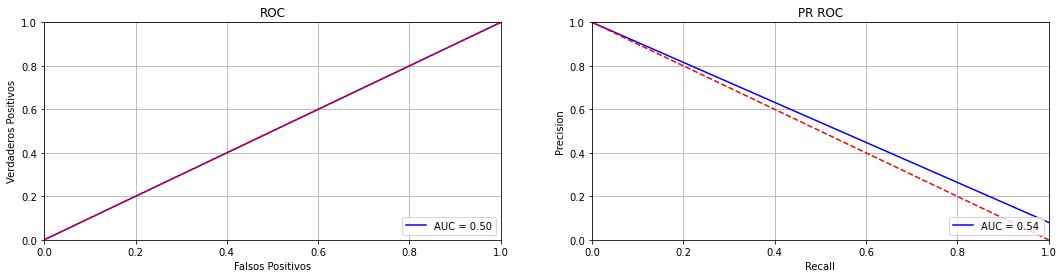

In [185]:
y_pred_NN_2 = modelNN_2.predict_proba(X_test[fs_2])

preds_NN_2 = y_pred_NN_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_2)
roc_auc_NN_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_2)
pr_roc_auc_NN_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [186]:
results['modelNN_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_2, 'prc': pr_roc_auc_NN_2}
results['modelNN_2']

{'acc': 0.9199268801038712,
 'rec': 0.0,
 'f1': 0.0,
 'auc': 0.5,
 'prc': 0.5400365599480643}

___

In [114]:
modelNN_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('classifier', MLPClassifier(verbose=True, batch_size=512, learning_rate_init=0.01, hidden_layer_sizes=(32,16,8,4,2), activation='relu', solver='adam', max_iter=19, alpha=0.001, random_state=1))
])

In [115]:
modelNN_3.fit(X_train[fs_3], y_train)

Iteration 1, loss = 0.20477713
Iteration 2, loss = 0.19989169
Iteration 3, loss = 0.19852499
Iteration 4, loss = 0.19837417
Iteration 5, loss = 0.19811526
Iteration 6, loss = 0.19783359
Iteration 7, loss = 0.19796823
Iteration 8, loss = 0.19771351
Iteration 9, loss = 0.19765954
Iteration 10, loss = 0.19759526
Iteration 11, loss = 0.19766141
Iteration 12, loss = 0.19746159
Iteration 13, loss = 0.19719897
Iteration 14, loss = 0.19723775
Iteration 15, loss = 0.19795491
Iteration 16, loss = 0.19731174
Iteration 17, loss = 0.19765644
Iteration 18, loss = 0.19718254
Iteration 19, loss = 0.19710565


/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/sklearn/neural_network/_multilayer_perceptron.py:614: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (19) reached and the optimization hasn't converged yet.
  warnings.warn(


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
                                                   'creation_platform',
     

Accuracy: 92.04%


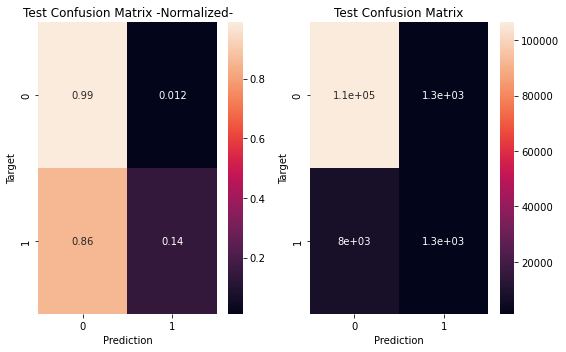

In [116]:
test_preds_NN_3 = modelNN_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_NN_3, y_test, 'Test')
acc = modelNN_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_NN_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_NN_3)

<ipython-input-117-031892fe047e>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


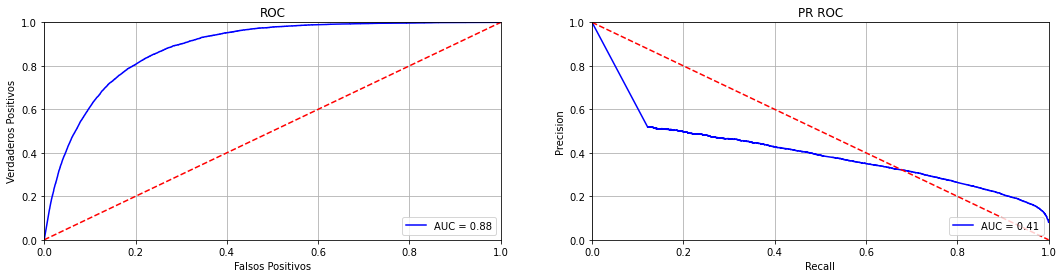

In [117]:
y_pred_NN_3 = modelNN_3.predict_proba(X_test[fs_3])

preds_NN_3 = y_pred_NN_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_NN_3)
roc_auc_NN_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_3)
pr_roc_auc_NN_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [118]:
results['modelNN_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_3, 'prc': pr_roc_auc_NN_3}
results['modelNN_3']

{'acc': 0.9204308606963474,
 'rec': 0.14262854704501812,
 'f1': 0.22303778463591623,
 'auc': 0.883549914906592,
 'prc': 0.4055702741091089}

___

#### 6.2.4 TF Neural Networks with cw

In [119]:
import tensorflow as tf
from tensorflow import feature_column

In [120]:
neg, pos = np.bincount(y_train)
weight_for_0 = (1 / neg) * ((neg+pos) / 2.0)
weight_for_1 = (1 / pos) * ((neg+pos) / 2.0)

Needed TF transformations

In [121]:
X_train_tf = X_train.copy()
X_test_tf = X_test.copy()

X_train_tf.columns

Index(['index', 'country', 'creation_platform', 'source_pulido',
       'creation_weekday', 'creation_hour', 'admin_visits',
       'intercom_conversations', 'products_with_description',
       'total_events_on_Android', 'total_events_on_Web', 'total_events_on_iOS',
       'total_product_categories', 'total_products_with_images',
       'total_events', 'total_mobile'],
      dtype='object')

In [122]:
df_tf_ohe = transformer.one_hot_encoding(X_train_tf[list(X_categorical.columns)])
X_train_tf = pd.concat([X_train_tf, df_tf_ohe], axis=1)
X_train_tf.head()

,index,country,creation_platform,source_pulido,creation_weekday,creation_hour,admin_visits,intercom_conversations,products_with_description,total_events_on_Android,...,14,15,16,17,18,19,20,21,22,23
0,493741,BR,mobile_web,Brand,Sunday,19,1.0,0.0,0.0,0.0,...,0,0,0,0,0,1,0,0,0,0
1,142515,BR,mobile_web,Facebook CPC,Monday,15,1.0,0.0,0.0,0.0,...,0,1,0,0,0,0,0,0,0,0
2,16997,AR,desktop,Google Organic,Saturday,3,1.0,0.0,3.0,0.0,...,0,0,0,0,0,0,0,0,0,0
3,549149,BR,desktop,Other,Sunday,0,2.0,0.0,8.0,0.0,...,0,0,0,0,0,0,0,0,0,0
4,365679,AR,desktop,Google Organic,Saturday,0,1.0,0.0,1.0,0.0,...,0,0,0,0,0,0,0,0,0,0


In [123]:
df_tf_ohe_test = transformer.one_hot_encoding(X_test_tf[list(X_categorical.columns)])
X_test_tf = pd.concat([X_test_tf, df_tf_ohe_test], axis=1)

In [124]:
METRICS = [
    tf.keras.metrics.TruePositives(name='tp'),
    tf.keras.metrics.FalsePositives(name='fp'),
    tf.keras.metrics.TrueNegatives(name='tn'),
    tf.keras.metrics.FalseNegatives(name='fn'),
    tf.keras.metrics.BinaryAccuracy(name='accuracy'),
    tf.keras.metrics.Precision(name='precision'),
    tf.keras.metrics.Recall(name='recall'),
    tf.keras.metrics.AUC(name='auc'),
    tf.keras.metrics.AUC(name='prc', curve='PR')
]

In [125]:
def create_model():
  # create model
  model = tf.keras.models.Sequential()
  model.add(tf.keras.layers.Dense(units=32, activation='relu'))
  model.add(tf.keras.layers.Dense(units=16, activation='relu'))
  model.add(tf.keras.layers.Dense(units=8, activation='relu'))
  model.add(tf.keras.layers.Dense(units=4, activation='relu'))
  model.add(tf.keras.layers.Dense(units=1, activation='sigmoid'))

  return model

model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

___

In [126]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_0])
X_train_tf[columns_0] = rb_scaler.transform(X_train_tf[columns_0])
X_test_tf[columns_0] = rb_scaler.transform(X_test_tf[columns_0])

In [127]:
history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_0].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)


Epoch 1/20
3659/3659 [==============================] - 11s 2ms/step - loss: 0.4513 - tp: 32154.0000 - fp: 117749.0000 - tn: 313028.0000 - fn: 5341.0000 - accuracy: 0.7371 - precision: 0.2145 - recall: 0.8576 - auc: 0.8690 - prc: 0.3602
Epoch 2/20
3659/3659 [==============================] - 10s 3ms/step - loss: 0.4359 - tp: 32407.0000 - fp: 115110.0000 - tn: 315667.0000 - fn: 5088.0000 - accuracy: 0.7433 - precision: 0.2197 - recall: 0.8643 - auc: 0.8776 - prc: 0.3729
Epoch 3/20
3659/3659 [==============================] - 9s 3ms/step - loss: 0.4289 - tp: 32197.0000 - fp: 109983.0000 - tn: 320794.0000 - fn: 5298.0000 - accuracy: 0.7538 - precision: 0.2265 - recall: 0.8587 - auc: 0.8799 - prc: 0.3810
Epoch 4/20
3659/3659 [==============================] - 7s 2ms/step - loss: 0.4264 - tp: 32087.0000 - fp: 107967.0000 - tn: 322810.0000 - fn: 5408.0000 - accuracy: 0.7579 - precision: 0.2291 - recall: 0.8558 - auc: 0.8811 - prc: 0.3841
Epoch 5/20
3659/3659 [==============================] 

Accuracy: 77.21%


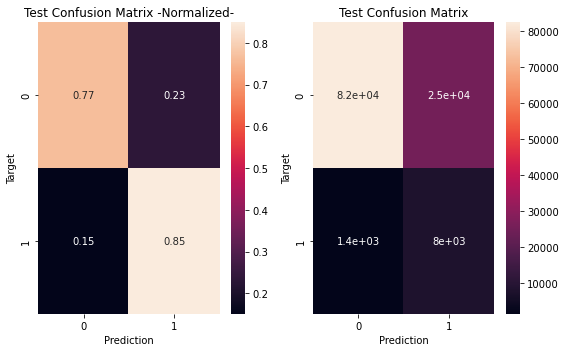

In [128]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_0].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-129-4e8f5d65f66e>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


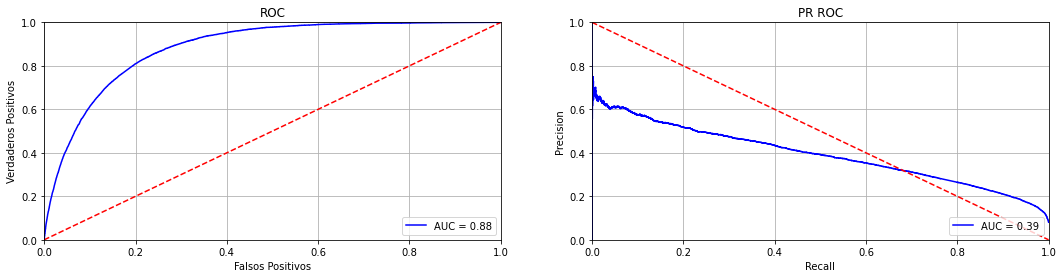

In [129]:
preds_NN_cw_0 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_0)
roc_auc_NN_cw_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_0)
pr_roc_auc_NN_cw_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [130]:
results['modelNN_cw_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_0, 'prc': pr_roc_auc_NN_cw_0}
results['modelNN_cw_0']

{'acc': 0.7721153517613695,
 'rec': 0.849050565393642,
 'f1': 0.3736970607568786,
 'auc': 0.8844944575022873,
 'prc': 0.3921547078950343}

___

In [131]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_1])
X_train_tf[columns_1] = rb_scaler.transform(X_train_tf[columns_1])
X_test_tf[columns_1] = rb_scaler.transform(X_test_tf[columns_1])

In [132]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_1].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)


Epoch 1/20
3659/3659 [==============================] - 11s 2ms/step - loss: 0.4993 - tp: 63034.0000 - fp: 210371.0000 - tn: 651183.0000 - fn: 11956.0000 - accuracy: 0.7626 - precision: 0.2306 - recall: 0.8406 - auc: 0.8702 - prc: 0.3700
Epoch 2/20
3659/3659 [==============================] - 10s 3ms/step - loss: 0.4465 - tp: 31574.0000 - fp: 105326.0000 - tn: 325451.0000 - fn: 5921.0000 - accuracy: 0.7624 - precision: 0.2306 - recall: 0.8421 - auc: 0.8760 - prc: 0.3740
Epoch 3/20
3659/3659 [==============================] - 9s 2ms/step - loss: 0.4380 - tp: 31703.0000 - fp: 105036.0000 - tn: 325741.0000 - fn: 5792.0000 - accuracy: 0.7633 - precision: 0.2319 - recall: 0.8455 - auc: 0.8785 - prc: 0.3749
Epoch 4/20
3659/3659 [==============================] - 7s 2ms/step - loss: 0.4319 - tp: 31739.0000 - fp: 104522.0000 - tn: 326255.0000 - fn: 5756.0000 - accuracy: 0.7645 - precision: 0.2329 - recall: 0.8465 - auc: 0.8804 - prc: 0.3799
Epoch 5/20
3659/3659 [==============================]

Accuracy: 76.21%


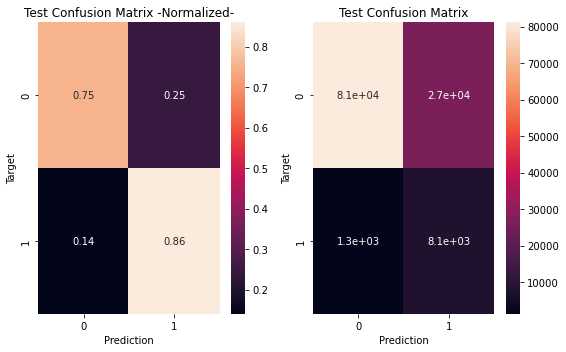

In [133]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_1].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-134-54f986049c16>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


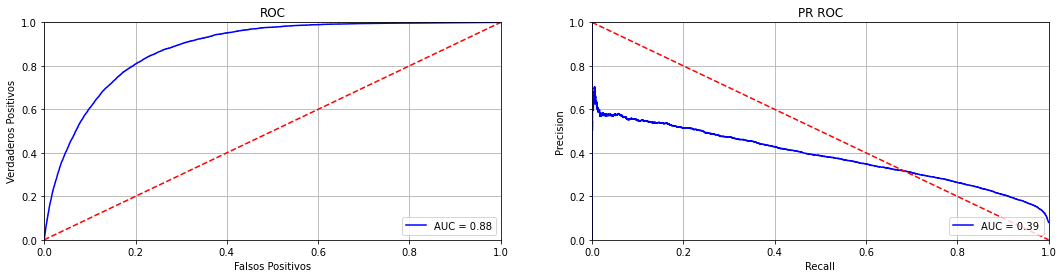

In [134]:
preds_NN_cw_1 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_1)
roc_auc_NN_cw_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_1)
pr_roc_auc_NN_cw_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [135]:
results['modelNN_cw_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_1, 'prc': pr_roc_auc_NN_cw_1}
results['modelNN_cw_1']

{'acc': 0.7621297023951891,
 'rec': 0.8598250480051205,
 'f1': 0.3666386153251302,
 'auc': 0.8831482650415737,
 'prc': 0.3852254510789811}

___

In [136]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_2])
X_train_tf[columns_2] = rb_scaler.transform(X_train_tf[columns_2])
X_test_tf[columns_2] = rb_scaler.transform(X_test_tf[columns_2])

In [137]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [138]:
history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_2].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)

Epoch 1/20
3659/3659 [==============================] - 7s 2ms/step - loss: 0.4717 - tp: 63719.0000 - fp: 220504.0000 - tn: 641050.0000 - fn: 11271.0000 - accuracy: 0.7525 - precision: 0.2242 - recall: 0.8497 - auc: 0.8674 - prc: 0.3387
Epoch 2/20
3659/3659 [==============================] - 6s 2ms/step - loss: 0.4308 - tp: 31870.0000 - fp: 106308.0000 - tn: 324469.0000 - fn: 5625.0000 - accuracy: 0.7610 - precision: 0.2306 - recall: 0.8500 - auc: 0.8770 - prc: 0.3372
Epoch 3/20
3659/3659 [==============================] - 6s 2ms/step - loss: 0.4274 - tp: 31903.0000 - fp: 105222.0000 - tn: 325555.0000 - fn: 5592.0000 - accuracy: 0.7634 - precision: 0.2327 - recall: 0.8509 - auc: 0.8791 - prc: 0.3463
Epoch 4/20
3659/3659 [==============================] - 6s 2ms/step - loss: 0.4251 - tp: 31897.0000 - fp: 103781.0000 - tn: 326996.0000 - fn: 5598.0000 - accuracy: 0.7664 - precision: 0.2351 - recall: 0.8507 - auc: 0.8806 - prc: 0.3543
Epoch 5/20
3659/3659 [==============================] -

Accuracy: 77.24%


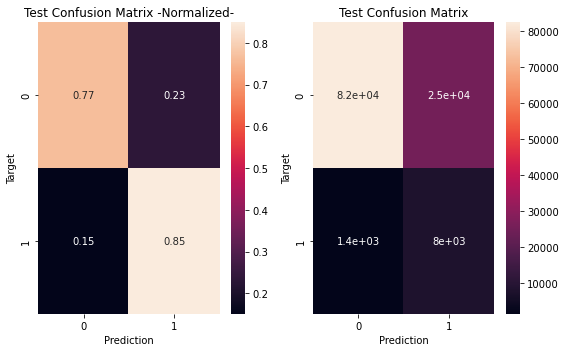

In [139]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_2].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-140-fcf56ce6c462>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


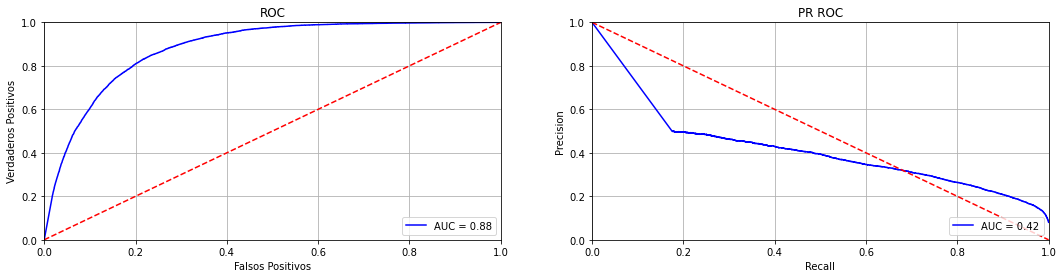

In [140]:
preds_NN_cw_2 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_2)
roc_auc_NN_cw_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_2)
pr_roc_auc_NN_cw_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [141]:
results['modelNN_cw_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_2, 'prc': pr_roc_auc_NN_cw_2}
results['modelNN_cw_2']

{'acc': 0.7724314073871597,
 'rec': 0.8486238532110092,
 'f1': 0.37390425606918753,
 'auc': 0.8829646234624365,
 'prc': 0.41668568162512826}

___

In [142]:
rb_scaler = RobustScaler().fit(X_train_tf[columns_reduced])
X_train_tf[columns_reduced] = rb_scaler.transform(X_train_tf[columns_reduced])
X_test_tf[columns_reduced] = rb_scaler.transform(X_test_tf[columns_reduced])

In [143]:
model = create_model()

model.compile(
    optimizer=tf.keras.optimizers.Adam(learning_rate=0.001),
    loss='binary_crossentropy',
    metrics=METRICS
)

In [144]:
history = model.fit(
    X_train_tf[list(df_tf_ohe.columns) + columns_reduced].values, 
    y_train.values,
    epochs=20,
    batch_size=128,
    class_weight={0: weight_for_0, 1: weight_for_1},
)

Epoch 1/20
3659/3659 [==============================] - 9s 2ms/step - loss: 0.4473 - tp: 63614.0000 - fp: 211143.0000 - tn: 650411.0000 - fn: 11376.0000 - accuracy: 0.7624 - precision: 0.2315 - recall: 0.8483 - auc: 0.8783 - prc: 0.3648
Epoch 2/20
3659/3659 [==============================] - 7s 2ms/step - loss: 0.4299 - tp: 31977.0000 - fp: 107440.0000 - tn: 323337.0000 - fn: 5518.0000 - accuracy: 0.7588 - precision: 0.2294 - recall: 0.8528 - auc: 0.8787 - prc: 0.3725
Epoch 3/20
3659/3659 [==============================] - 7s 2ms/step - loss: 0.4275 - tp: 31989.0000 - fp: 106914.0000 - tn: 323863.0000 - fn: 5506.0000 - accuracy: 0.7599 - precision: 0.2303 - recall: 0.8532 - auc: 0.8803 - prc: 0.3779
Epoch 4/20
3659/3659 [==============================] - 7s 2ms/step - loss: 0.4259 - tp: 31986.0000 - fp: 106164.0000 - tn: 324613.0000 - fn: 5509.0000 - accuracy: 0.7615 - precision: 0.2315 - recall: 0.8531 - auc: 0.8811 - prc: 0.3786
Epoch 5/20
3659/3659 [==============================] -

Accuracy: 76.58%


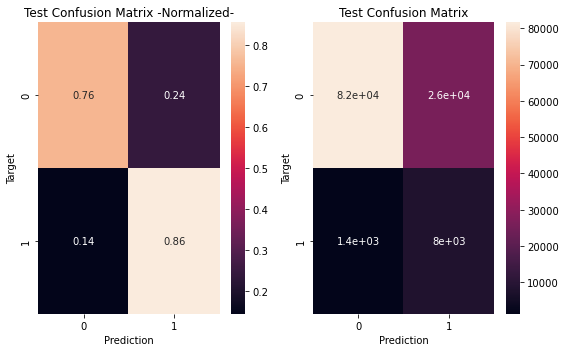

In [145]:
test_predictions = model.predict(X_test_tf[list(df_tf_ohe.columns) + columns_reduced].values)
plot_utils.predict_and_plot(np.rint(test_predictions), y_test, 'Test')
acc = accuracy_score(y_true=y_test, y_pred=np.rint(test_predictions))
rec = recall_score(y_true=y_test, y_pred=np.rint(test_predictions))
f1 = f1_score(y_true=y_test, y_pred=np.rint(test_predictions))

<ipython-input-146-497360a801a7>:31: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


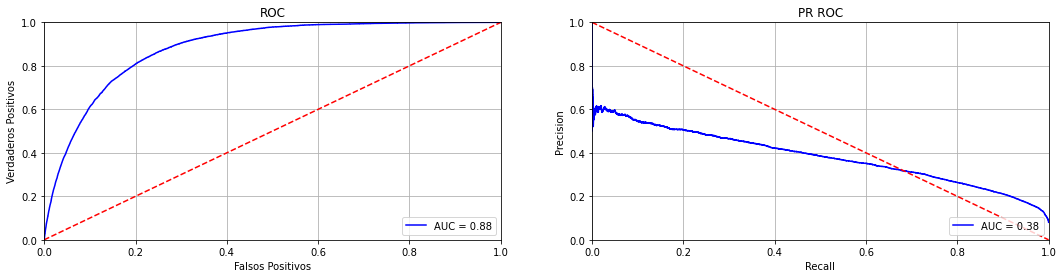

In [146]:
preds_NN_cw_3 = test_predictions

fpr, tpr, threshold = roc_curve(y_test, preds_NN_cw_3)
roc_auc_NN_cw_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_NN_cw_3)
pr_roc_auc_NN_cw_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_NN_cw_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_cw_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [147]:
results['modelNN_cw_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_NN_cw_3, 'prc': pr_roc_auc_NN_cw_3}
results['modelNN_cw_3']

{'acc': 0.7657515290258653,
 'rec': 0.8557712822701088,
 'f1': 0.36910759886810685,
 'auc': 0.8833896303852072,
 'prc': 0.3833479238123378}

#### 6.2.5 XGBoost

In [150]:
modelXGB_0 = Pipeline(steps=[
    ('preprocessor', preprocessor_0),
    ('classifier', xgb.XGBClassifier(n_estimators=20, max_depth=10))
])

In [151]:
modelXGB_0.fit(X_train[fs_0], y_train)

/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:22:40] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Android',
                                                   'total_events_on_Web',
                                                   'total_events_on_iOS',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown

Accuracy: 92.15%


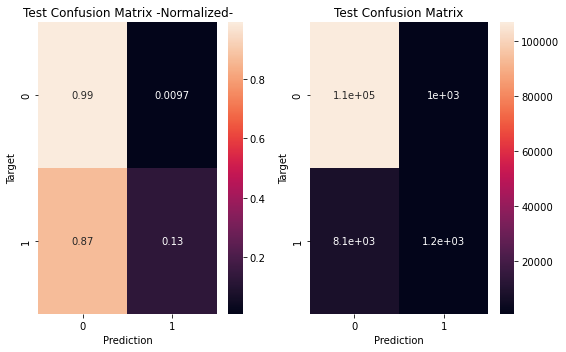

In [152]:
test_preds_XGB_0 = modelXGB_0.predict(X_test[fs_0])
plot_utils.predict_and_plot(test_preds_XGB_0, y_test, 'Test')
acc = modelXGB_0.score(X_test[fs_0], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_0)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_0)

<ipython-input-153-d239e1a12189>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


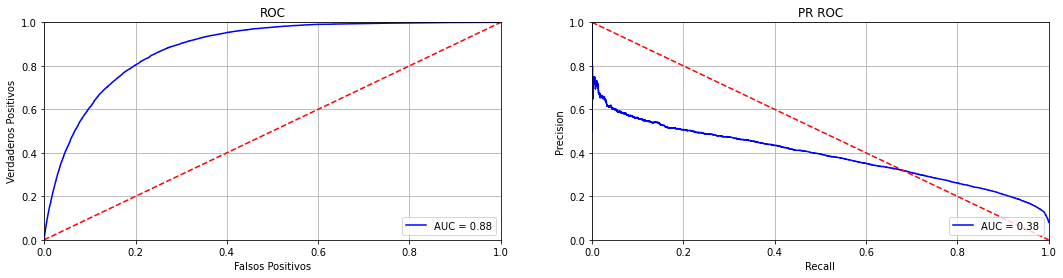

In [153]:
y_pred_XGB_0 = modelXGB_0.predict_proba(X_test[fs_0])

preds_XGB_0 = y_pred_XGB_0[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_0)
roc_auc_XGB_0 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_0)
pr_roc_auc_XGB_0 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_0)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_NN_0)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [174]:
results['modelXGB_0'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_0, 'prc': pr_roc_auc_XGB_0}
results['modelXGB_0']

{'acc': 0.9142891311032904,
 'rec': 0.1956475357371453,
 'f1': 0.267698146256021,
 'auc': 0.8838299965335332,
 'prc': 0.38962975582681636}

___

In [158]:
modelXGB_1 = Pipeline(steps=[
    ('preprocessor', preprocessor_1),
    ('classifier', xgb.XGBClassifier())
])

In [159]:
modelXGB_1.fit(X_train[fs_1], y_train)

/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:26:58] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_mobile']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=Fal

Accuracy: 92.18%


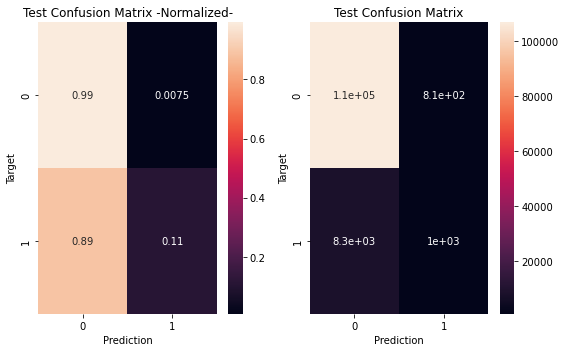

In [160]:
test_preds_XGB_1 = modelNN_1.predict(X_test[fs_1])
plot_utils.predict_and_plot(test_preds_XGB_1, y_test, 'Test')
acc = modelNN_1.score(X_test[fs_1], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_1)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_1)

<ipython-input-161-545facbd5cf3>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


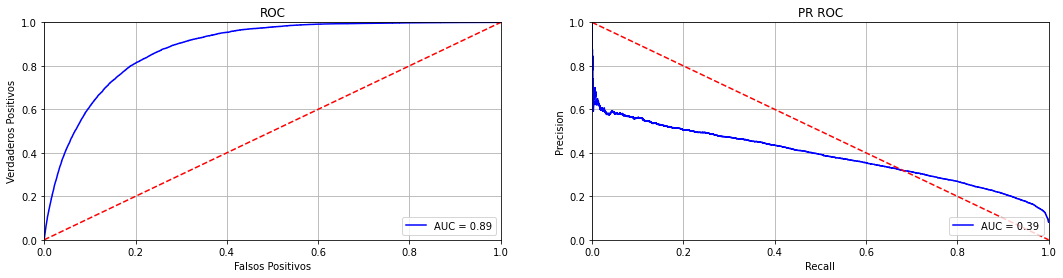

In [161]:
y_pred_XGB_1 = modelXGB_1.predict_proba(X_test[fs_1])

preds_XGB_1 = y_pred_XGB_1[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_1)
roc_auc_XGB_1 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_1)
pr_roc_auc_XGB_1 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_1)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_XGB_1)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [162]:
results['modelXGB_1'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_1, 'prc': pr_roc_auc_XGB_1}
results['modelXGB_1']

{'acc': 0.9218317559025524,
 'rec': 0.11009174311926606,
 'f1': 0.18403923316986182,
 'auc': 0.8854827915476596,
 'prc': 0.388763289050435}

___

In [163]:
modelXGB_2 = Pipeline(steps=[
    ('preprocessor', preprocessor_2),
    ('classifier', xgb.XGBClassifier(n_estimators=20, max_depth=50))
])

In [164]:
modelXGB_2.fit(X_train[fs_2], y_train)

/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:30:26] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'intercom_conversations',
                                                   'products_with_description',
                                                   'total_product_categories',
                                                   'total_products_with_images',
                                                   'total_events']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
       

Accuracy: 91.37%


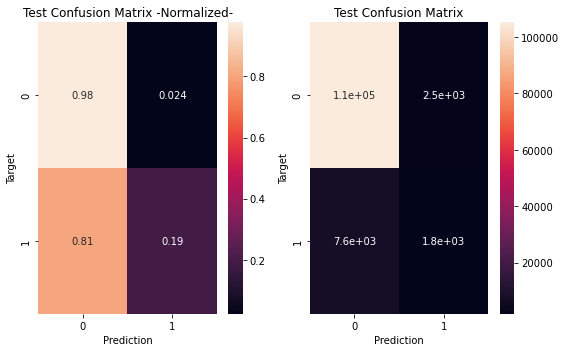

In [165]:
test_preds_XGB_2 = modelXGB_2.predict(X_test[fs_2])
plot_utils.predict_and_plot(test_preds_XGB_2, y_test, 'Test')
acc = modelXGB_2.score(X_test[fs_2], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_2)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_2)

<ipython-input-166-88a2e6775c4b>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


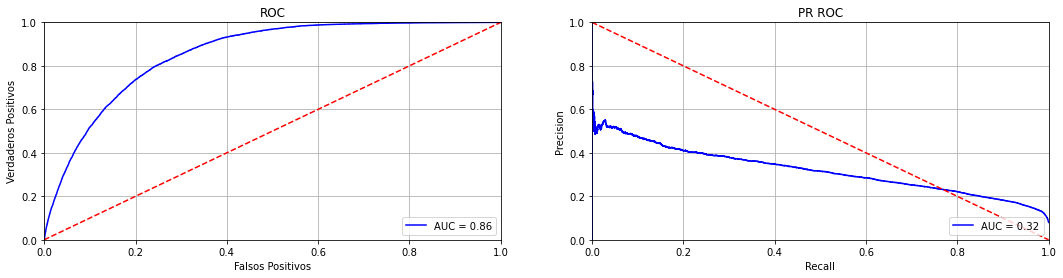

In [166]:
y_pred_XGB_2 = modelXGB_2.predict_proba(X_test[fs_2])

preds_XGB_2 = y_pred_XGB_2[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_2)
roc_auc_XGB_2 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_2)
pr_roc_auc_XGB_2 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_2)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_XGB_2)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [167]:
results['modelXGB_2'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_2, 'prc': pr_roc_auc_XGB_2}
results['modelXGB_2']

{'acc': 0.9136570198517101,
 'rec': 0.1929805845956902,
 'f1': 0.2635873524697654,
 'auc': 0.8562759703449653,
 'prc': 0.31976554398590473}

___

In [168]:
modelXGB_3 = Pipeline(steps=[
    ('preprocessor', preprocessor_3),
    ('classifier', xgb.XGBClassifier(n_estimators=20, max_depth=50))
])

In [169]:
modelXGB_3.fit(X_train[fs_3], y_train)

/Users/ext_asalassa/opt/anaconda3/lib/python3.8/site-packages/xgboost/sklearn.py:1224: UserWarning: The use of label encoder in XGBClassifier is deprecated and will be removed in a future release. To remove this warning, do the following: 1) Pass option use_label_encoder=False when constructing XGBClassifier object; and 2) Encode your labels (y) as integers starting with 0, i.e. 0, 1, 2, ..., [num_class - 1].
  warnings.warn(label_encoder_deprecation_msg, UserWarning)


[14:32:33] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:1115: Starting in XGBoost 1.3.0, the default evaluation metric used with the objective 'binary:logistic' was changed from 'error' to 'logloss'. Explicitly set eval_metric if you'd like to restore the old behavior.


Pipeline(steps=[('preprocessor',
                 ColumnTransformer(transformers=[('num',
                                                  Pipeline(steps=[('scaler',
                                                                   RobustScaler())]),
                                                  ['admin_visits',
                                                   'products_with_description',
                                                   'total_events_on_Web',
                                                   'total_product_categories',
                                                   'total_products_with_images']),
                                                 ('cat',
                                                  OneHotEncoder(handle_unknown='ignore',
                                                                sparse=False),
                                                  ['country',
                                                   'creation_platform',
     

Accuracy: 91.43%


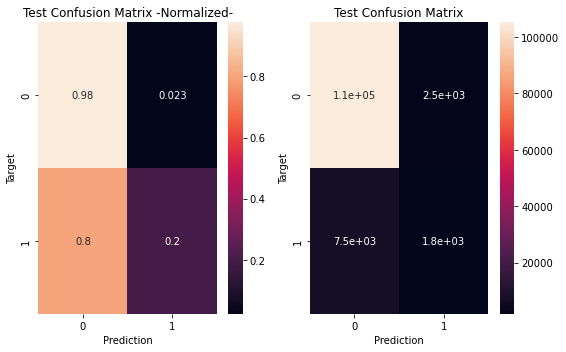

In [170]:
test_preds_XGB_3 = modelXGB_3.predict(X_test[fs_3])
plot_utils.predict_and_plot(test_preds_XGB_3, y_test, 'Test')
acc = modelXGB_3.score(X_test[fs_3], y_test)
rec = recall_score(y_true=y_test, y_pred=test_preds_XGB_3)
f1 = f1_score(y_true=y_test, y_pred=test_preds_XGB_3)

<ipython-input-171-236e0d960743>:33: UserWarning: Matplotlib is currently using module://ipykernel.pylab.backend_inline, which is a non-GUI backend, so cannot show the figure.
  fig.show()


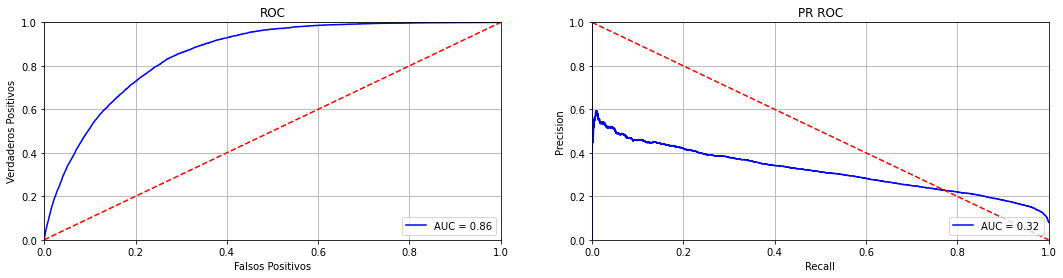

In [171]:
y_pred_XGB_3 = modelXGB_3.predict_proba(X_test[fs_3])

preds_XGB_3 = y_pred_XGB_3[:,1]

fpr, tpr, threshold = roc_curve(y_test, preds_XGB_3)
roc_auc_XGB_3 = auc(fpr, tpr)

pr_pre, pr_recc, threshold = precision_recall_curve(y_test, preds_XGB_3)
pr_roc_auc_XGB_3 = auc(pr_recc, pr_pre)

fig, axes = plt.subplots(1,2,figsize=(18,4))

axes[0].grid()
axes[0].set_title('ROC')
axes[0].plot(fpr, tpr, 'b', label = 'AUC = %0.2f' % roc_auc_XGB_3)
axes[0].legend(loc = 'lower right')
axes[0].plot([0, 1], [0, 1],'r--')
axes[0].set_xlim([0, 1])
axes[0].set_ylim([0, 1])
axes[0].set_ylabel('Verdaderos Positivos')
axes[0].set_xlabel('Falsos Positivos')

axes[1].grid()
axes[1].set_title('PR ROC')
axes[1].plot(pr_recc, pr_pre, 'b', label = 'AUC = %0.2f' % pr_roc_auc_XGB_3)
axes[1].legend(loc = 'lower right')
axes[1].plot([0, 1], [1, 0],'r--')
axes[1].set_xlim([0, 1])
axes[1].set_ylim([0, 1])
axes[1].set_ylabel('Precision')
axes[1].set_xlabel('Recall')

fig.show()

In [172]:
results['modelXGB_3'] = {'acc': acc, 'rec': rec, 'f1': f1, 'auc': roc_auc_XGB_3, 'prc': pr_roc_auc_XGB_3}
results['modelXGB_3']

{'acc': 0.9142891311032904,
 'rec': 0.1956475357371453,
 'f1': 0.267698146256021,
 'auc': 0.855453594784667,
 'prc': 0.31826331197482277}

___
## 7. Summary

In [176]:
print('Model results:')
df_results = pd.DataFrame.from_dict(results)
df_results.T

Model results:


,acc,rec,f1,auc,prc
modelLR_0,0.920183,0.140602,0.220033,0.860809,0.351910
modelLR_1,0.920781,0.136441,0.216193,0.860794,0.351405
modelLR_2,0.920414,0.108492,0.179191,0.860457,0.347091
modelLR_3,0.920935,0.128014,0.205903,0.864245,0.356710
modelRF_0,0.912512,0.158310,0.224678,0.845632,0.303590
modelRF_1,0.912905,0.160977,0.228394,0.844502,0.302952
modelRF_2,0.912265,0.163431,0.229771,0.842844,0.299600
modelRF_3,0.912162,0.163537,0.229680,0.843892,0.299687
modelNN_0,0.920456,0.111265,0.183015,0.883679,0.375535
modelNN_1,0.921832,0.110092,0.184039,0.884006,0.401702


Based on the f1 score, the best perfomances were achieved by the models using class weights. More techniques could be implemented to attack the imbalanced data problem (oversampling, SMOTE, etc).